In [1]:
import numpy as np
%matplotlib inline
from scipy.io import loadmat
import matplotlib.pyplot as plt
from functions import Model, plot_velocity, plot_stacking_chart, TimeAxis, RickerSource, Receiver
from devito import TimeFunction
from devito import Eq, solve
from devito import Operator
from scipy.io import savemat
import os
import imageio

In [2]:
model_reshaped = np.load('data/reshaped3dmodel.npy')
shape = (101,101,101)

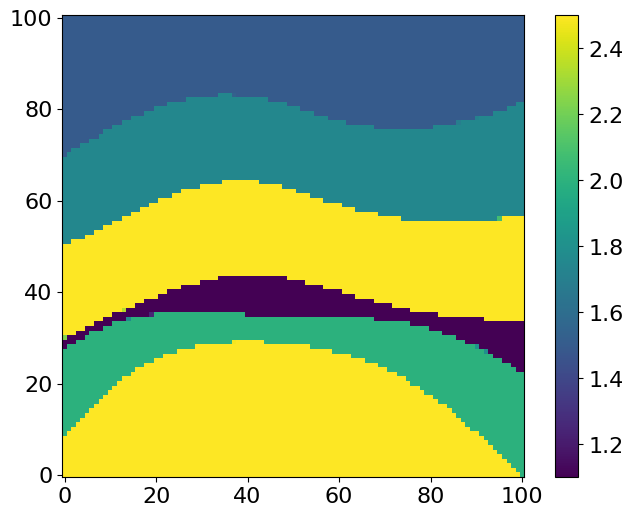

In [3]:
plt.imshow(model_reshaped[50].T, cmap='viridis', origin='lower')
plt.colorbar()
plt.show()

In [4]:
model_reshaped[50].T.shape

(101, 101)

In [5]:
model = Model(vp=model_reshaped, origin=(0., 0., -1000), spacing=(10., 10., 10.), shape=shape, nbl=30, space_order=4, bcs="damp")

Operator `initdamp` ran in 0.01 s


In [54]:
list_x=[]
list_y=[]
list_en=[]
list_sp=[]

en=1
sp=1

for J in range(3):
    for I in range(4): 
        
        if J == 1:
            new_x0_y = 300-I*100
            en = 301-(100*I) + (10*J)
            sp = 16 - (5*I) + (200*J)
        else:
            new_x0_y = I*100
            en = 1+ (100*I) + (10*J)
            sp = 1+ (200*J) + (5*I)
            
        new_x0_x = J*200
        
        list_en.append(en)
        list_sp.append(sp)

        list_x.append(new_x0_x)
        list_y.append(new_x0_y)

print(list_x)
print(list_y)

[0, 0, 0, 0, 200, 200, 200, 200, 400, 400, 400, 400]
[0, 100, 200, 300, 300, 200, 100, 0, 0, 100, 200, 300]


In [55]:
def modeling_3D_swath(list_x,list_y):
    num_swath = 1    
    ffid = 1
    
    for i in range(len(list_x)):        
        print('Swath: ',num_swath)
        
        L_rec = 600 # Length line of receivers
        L_sx = 500 # Length line of sources
        x0_x = list_x[num_swath-1] # Initial position in X
        x0_y = list_y[num_swath-1] # Initial position in Y

        #line of sources
        num_sources = 25
        sx_line = np.linspace(x0_y+10,L_sx+x0_y-10,num=num_sources)
        #line of receivers
        num_receivers = 61
        rec_line = np.linspace(x0_x,L_rec+x0_x,num=num_receivers)
        #lines of receivers
        num_rec_lines = 6
        rec_lines = np.linspace(x0_y,L_sx+x0_y,num=num_rec_lines)
        #lines of sources
        num_sx_lines = 3
        sx_lines = np.linspace(x0_x+200,x0_x+400,num=num_sx_lines)
        #matriz of receivers
        matriz_rec = np.zeros((num_rec_lines,len(rec_line)))     
        for i in range(num_rec_lines):
            for j in range(len(rec_line)):
                matriz_rec[i,j] = rec_line[j]
                
        plt.figure()
        for i in range(num_rec_lines):
            for j in range(len(rec_line)):
                plt.plot(rec_line[j],rec_lines[i],'bs',mfc='none')

        for i in range(num_sx_lines):
            for j in range(len(sx_line)):
                plt.plot(sx_lines[i],sx_line[j],'r*')

        plt.xlabel('Distance X (m)')
        plt.ylabel('Distance Y (m)')
        plt.show()
                
        survey = []
        for j in range(num_sx_lines):
            for i in range(num_sources):
                print('FFID: ',ffid)
                
                inicial = rec_lines[0]
                final = rec_lines[-1]

                line_rec_x = matriz_rec[0,:]
                line_rec_y = np.linspace(inicial,final,len(matriz_rec[:,0])) 

                sx_x = sx_lines[j]
                sx_y = sx_line[i]
                print(sx_x,sx_y)

                t0 = 0.  # Simulation starts a t=0
                tn = 1000.  # Simulation last 1 second (1000 ms)
                dt = model.critical_dt  # Time step from model grid spacing

                time_range = TimeAxis(start=t0, stop=tn, step=dt)

                #Source
                f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
                src = RickerSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)
                src.coordinates.data[0, 0] = sx_x
                src.coordinates.data[0, 1] = sx_y
                src.coordinates.data[0, -1] = 20.  # Depth is 20m

                #Receiver
                num_receivers = len(line_rec_x)
                num_lines = len(line_rec_y)

                rec = Receiver(name='rec', grid=model.grid, npoint=num_receivers*num_lines, time_range=time_range)

                for k in range(num_lines):
                    rec.coordinates.data[k*num_receivers:(k+1)*num_receivers, 0] = line_rec_x  
                    rec.coordinates.data[k*num_receivers:(k+1)*num_receivers, 1] = line_rec_y[k]   

                rec.coordinates.data[:, -1] = 20. # Depth is 20m

                # Define the wavefield with the size of the model
                u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=4)

                # We can now write the PDE
                pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

                stencil = Eq(u.forward, solve(pde, u.forward))

                # Finally we define the source injection and receiver read function to generate the corresponding code
                src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

                # Create interpolation expression for receivers
                rec_term = rec.interpolate(expr=u.forward)

                op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

                op(time=time_range.num-1, dt=model.critical_dt)

                survey.append(rec.data)

                ffid +=1
                
        print(len(survey))       
        plt.figure()
        plt.imshow(survey[74], cmap='viridis', aspect='auto', extent=(0,rec.data.shape[1],1,0), vmax=0.01, vmin=-0.01)
        plt.xlabel('traces')
        plt.ylabel('time (s)')
        plt.show()
        
        print(survey[74].shape)
        
        for i in range(len(survey)): 
            np.savetxt('data/datatxt2/swath_'+str(num_swath)+'/file_'+str(i+1)+'.txt',survey[i].T.ravel())
            print(i)
            
        num_swath +=1

Swath:  1


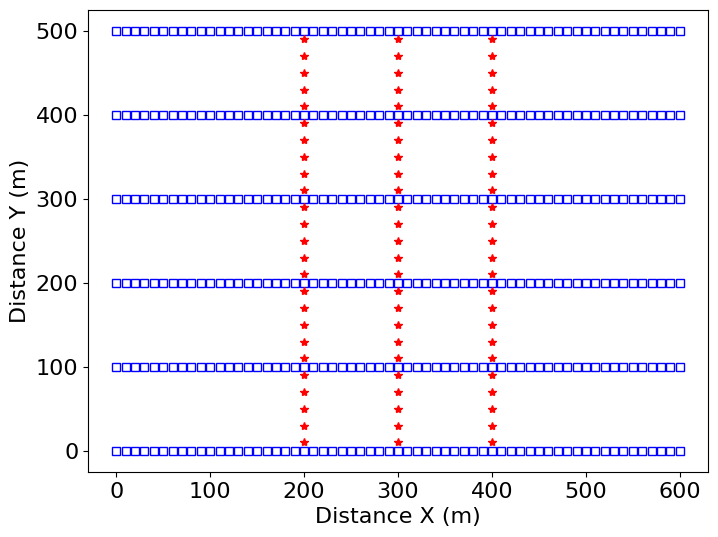

FFID:  1
200.0 10.0


Operator `Kernel` ran in 4.22 s


FFID:  2
200.0 30.0


Operator `Kernel` ran in 4.11 s


FFID:  3
200.0 50.0


Operator `Kernel` ran in 4.32 s


FFID:  4
200.0 70.0


Operator `Kernel` ran in 4.32 s


FFID:  5
200.0 90.0


Operator `Kernel` ran in 4.17 s


FFID:  6
200.0 110.0


Operator `Kernel` ran in 4.44 s


FFID:  7
200.0 130.0


Operator `Kernel` ran in 4.41 s


FFID:  8
200.0 150.0


Operator `Kernel` ran in 4.09 s


FFID:  9
200.0 170.0


Operator `Kernel` ran in 4.46 s


FFID:  10
200.0 190.0


Operator `Kernel` ran in 4.36 s


FFID:  11
200.0 210.0


Operator `Kernel` ran in 4.37 s


FFID:  12
200.0 230.0


Operator `Kernel` ran in 4.34 s


FFID:  13
200.0 250.0


Operator `Kernel` ran in 4.52 s


FFID:  14
200.0 270.0


Operator `Kernel` ran in 4.23 s


FFID:  15
200.0 290.0


Operator `Kernel` ran in 4.46 s


FFID:  16
200.0 310.0


Operator `Kernel` ran in 4.28 s


FFID:  17
200.0 330.0


Operator `Kernel` ran in 4.22 s


FFID:  18
200.0 350.0


Operator `Kernel` ran in 4.30 s


FFID:  19
200.0 370.0


Operator `Kernel` ran in 4.33 s


FFID:  20
200.0 390.0


Operator `Kernel` ran in 4.28 s


FFID:  21
200.0 410.0


Operator `Kernel` ran in 4.23 s


FFID:  22
200.0 430.0


Operator `Kernel` ran in 4.26 s


FFID:  23
200.0 450.0


Operator `Kernel` ran in 4.38 s


FFID:  24
200.0 470.0


Operator `Kernel` ran in 4.61 s


FFID:  25
200.0 490.0


Operator `Kernel` ran in 4.38 s


FFID:  26
300.0 10.0


Operator `Kernel` ran in 4.42 s


FFID:  27
300.0 30.0


Operator `Kernel` ran in 4.25 s


FFID:  28
300.0 50.0


Operator `Kernel` ran in 4.31 s


FFID:  29
300.0 70.0


Operator `Kernel` ran in 4.35 s


FFID:  30
300.0 90.0


Operator `Kernel` ran in 4.20 s


FFID:  31
300.0 110.0


Operator `Kernel` ran in 4.23 s


FFID:  32
300.0 130.0


Operator `Kernel` ran in 4.17 s


FFID:  33
300.0 150.0


Operator `Kernel` ran in 4.26 s


FFID:  34
300.0 170.0


Operator `Kernel` ran in 5.41 s


FFID:  35
300.0 190.0


Operator `Kernel` ran in 4.97 s


FFID:  36
300.0 210.0


Operator `Kernel` ran in 4.47 s


FFID:  37
300.0 230.0


Operator `Kernel` ran in 4.59 s


FFID:  38
300.0 250.0


Operator `Kernel` ran in 4.57 s


FFID:  39
300.0 270.0


Operator `Kernel` ran in 4.28 s


FFID:  40
300.0 290.0


Operator `Kernel` ran in 4.77 s


FFID:  41
300.0 310.0


Operator `Kernel` ran in 4.42 s


FFID:  42
300.0 330.0


Operator `Kernel` ran in 4.35 s


FFID:  43
300.0 350.0


Operator `Kernel` ran in 4.12 s


FFID:  44
300.0 370.0


Operator `Kernel` ran in 4.35 s


FFID:  45
300.0 390.0


Operator `Kernel` ran in 4.57 s


FFID:  46
300.0 410.0


Operator `Kernel` ran in 4.61 s


FFID:  47
300.0 430.0


Operator `Kernel` ran in 4.42 s


FFID:  48
300.0 450.0


Operator `Kernel` ran in 4.41 s


FFID:  49
300.0 470.0


Operator `Kernel` ran in 4.40 s


FFID:  50
300.0 490.0


Operator `Kernel` ran in 4.91 s


FFID:  51
400.0 10.0


Operator `Kernel` ran in 4.54 s


FFID:  52
400.0 30.0


Operator `Kernel` ran in 4.90 s


FFID:  53
400.0 50.0


Operator `Kernel` ran in 4.59 s


FFID:  54
400.0 70.0


Operator `Kernel` ran in 4.34 s


FFID:  55
400.0 90.0


Operator `Kernel` ran in 4.45 s


FFID:  56
400.0 110.0


Operator `Kernel` ran in 4.13 s


FFID:  57
400.0 130.0


Operator `Kernel` ran in 4.29 s


FFID:  58
400.0 150.0


Operator `Kernel` ran in 4.35 s


FFID:  59
400.0 170.0


Operator `Kernel` ran in 4.13 s


FFID:  60
400.0 190.0


Operator `Kernel` ran in 4.09 s


FFID:  61
400.0 210.0


Operator `Kernel` ran in 4.16 s


FFID:  62
400.0 230.0


Operator `Kernel` ran in 4.20 s


FFID:  63
400.0 250.0


Operator `Kernel` ran in 4.76 s


FFID:  64
400.0 270.0


Operator `Kernel` ran in 4.27 s


FFID:  65
400.0 290.0


Operator `Kernel` ran in 4.48 s


FFID:  66
400.0 310.0


Operator `Kernel` ran in 4.75 s


FFID:  67
400.0 330.0


Operator `Kernel` ran in 4.48 s


FFID:  68
400.0 350.0


Operator `Kernel` ran in 4.41 s


FFID:  69
400.0 370.0


Operator `Kernel` ran in 4.40 s


FFID:  70
400.0 390.0


Operator `Kernel` ran in 4.40 s


FFID:  71
400.0 410.0


Operator `Kernel` ran in 4.43 s


FFID:  72
400.0 430.0


Operator `Kernel` ran in 4.49 s


FFID:  73
400.0 450.0


Operator `Kernel` ran in 4.35 s


FFID:  74
400.0 470.0


Operator `Kernel` ran in 4.42 s


FFID:  75
400.0 490.0


Operator `Kernel` ran in 4.26 s


75


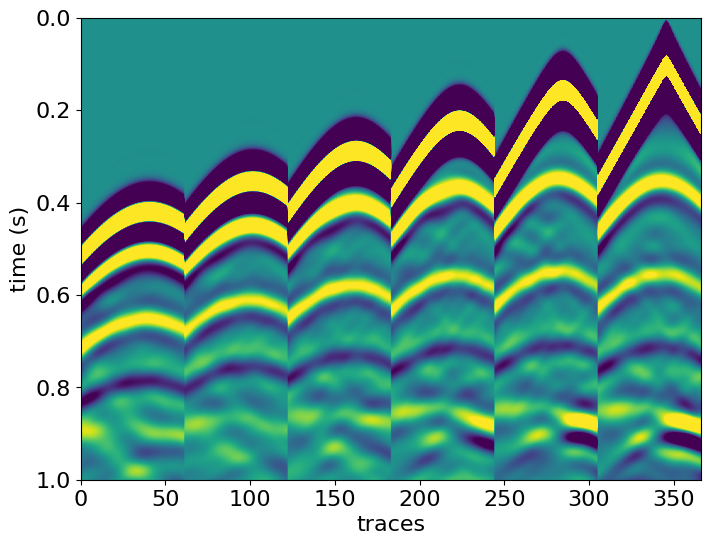

(554, 366)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Swath:  2


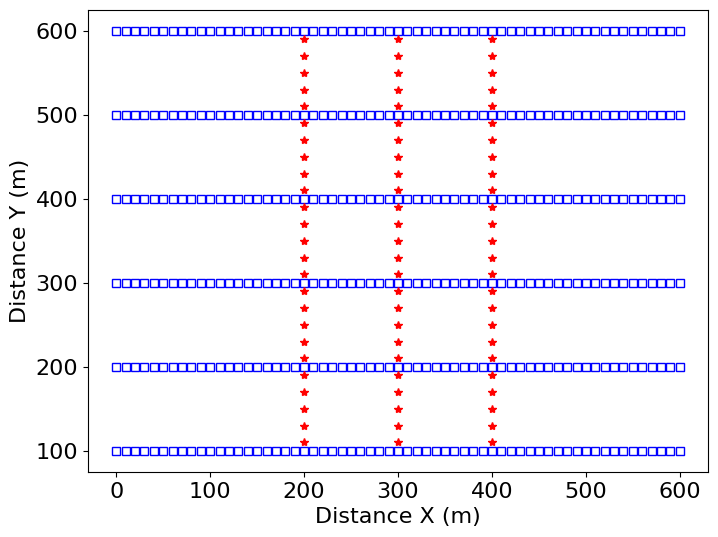

FFID:  76
200.0 110.0


Operator `Kernel` ran in 4.58 s


FFID:  77
200.0 130.0


Operator `Kernel` ran in 4.43 s


FFID:  78
200.0 150.0


Operator `Kernel` ran in 4.36 s


FFID:  79
200.0 170.0


Operator `Kernel` ran in 4.35 s


FFID:  80
200.0 190.0


Operator `Kernel` ran in 5.02 s


FFID:  81
200.0 210.0


Operator `Kernel` ran in 4.90 s


FFID:  82
200.0 230.0


Operator `Kernel` ran in 4.38 s


FFID:  83
200.0 250.0


Operator `Kernel` ran in 4.46 s


FFID:  84
200.0 270.0


Operator `Kernel` ran in 4.34 s


FFID:  85
200.0 290.0


Operator `Kernel` ran in 4.56 s


FFID:  86
200.0 310.0


Operator `Kernel` ran in 4.37 s


FFID:  87
200.0 330.0


Operator `Kernel` ran in 4.28 s


FFID:  88
200.0 350.0


Operator `Kernel` ran in 4.32 s


FFID:  89
200.0 370.0


Operator `Kernel` ran in 4.50 s


FFID:  90
200.0 390.0


Operator `Kernel` ran in 4.14 s


FFID:  91
200.0 410.0


Operator `Kernel` ran in 4.31 s


FFID:  92
200.0 430.0


Operator `Kernel` ran in 4.14 s


FFID:  93
200.0 450.0


Operator `Kernel` ran in 4.15 s


FFID:  94
200.0 470.0


Operator `Kernel` ran in 4.15 s


FFID:  95
200.0 490.0


Operator `Kernel` ran in 4.19 s


FFID:  96
200.0 510.0


Operator `Kernel` ran in 4.09 s


FFID:  97
200.0 530.0


Operator `Kernel` ran in 4.35 s


FFID:  98
200.0 550.0


Operator `Kernel` ran in 4.15 s


FFID:  99
200.0 570.0


Operator `Kernel` ran in 4.17 s


FFID:  100
200.0 590.0


Operator `Kernel` ran in 4.14 s


FFID:  101
300.0 110.0


Operator `Kernel` ran in 4.22 s


FFID:  102
300.0 130.0


Operator `Kernel` ran in 4.19 s


FFID:  103
300.0 150.0


Operator `Kernel` ran in 4.09 s


FFID:  104
300.0 170.0


Operator `Kernel` ran in 4.70 s


FFID:  105
300.0 190.0


Operator `Kernel` ran in 4.22 s


FFID:  106
300.0 210.0


Operator `Kernel` ran in 4.14 s


FFID:  107
300.0 230.0


Operator `Kernel` ran in 4.84 s


FFID:  108
300.0 250.0


Operator `Kernel` ran in 4.72 s


FFID:  109
300.0 270.0


Operator `Kernel` ran in 4.52 s


FFID:  110
300.0 290.0


Operator `Kernel` ran in 4.44 s


FFID:  111
300.0 310.0


Operator `Kernel` ran in 4.44 s


FFID:  112
300.0 330.0


Operator `Kernel` ran in 4.95 s


FFID:  113
300.0 350.0


Operator `Kernel` ran in 4.33 s


FFID:  114
300.0 370.0


Operator `Kernel` ran in 4.25 s


FFID:  115
300.0 390.0


Operator `Kernel` ran in 4.40 s


FFID:  116
300.0 410.0


Operator `Kernel` ran in 4.27 s


FFID:  117
300.0 430.0


Operator `Kernel` ran in 4.43 s


FFID:  118
300.0 450.0


Operator `Kernel` ran in 4.23 s


FFID:  119
300.0 470.0


Operator `Kernel` ran in 4.26 s


FFID:  120
300.0 490.0


Operator `Kernel` ran in 4.45 s


FFID:  121
300.0 510.0


Operator `Kernel` ran in 4.19 s


FFID:  122
300.0 530.0


Operator `Kernel` ran in 4.22 s


FFID:  123
300.0 550.0


Operator `Kernel` ran in 4.17 s


FFID:  124
300.0 570.0


Operator `Kernel` ran in 4.40 s


FFID:  125
300.0 590.0


Operator `Kernel` ran in 4.42 s


FFID:  126
400.0 110.0


Operator `Kernel` ran in 4.29 s


FFID:  127
400.0 130.0


Operator `Kernel` ran in 4.30 s


FFID:  128
400.0 150.0


Operator `Kernel` ran in 4.34 s


FFID:  129
400.0 170.0


Operator `Kernel` ran in 4.32 s


FFID:  130
400.0 190.0


Operator `Kernel` ran in 4.39 s


FFID:  131
400.0 210.0


Operator `Kernel` ran in 4.20 s


FFID:  132
400.0 230.0


Operator `Kernel` ran in 4.19 s


FFID:  133
400.0 250.0


Operator `Kernel` ran in 4.41 s


FFID:  134
400.0 270.0


Operator `Kernel` ran in 4.28 s


FFID:  135
400.0 290.0


Operator `Kernel` ran in 4.10 s


FFID:  136
400.0 310.0


Operator `Kernel` ran in 4.37 s


FFID:  137
400.0 330.0


Operator `Kernel` ran in 4.25 s


FFID:  138
400.0 350.0


Operator `Kernel` ran in 4.55 s


FFID:  139
400.0 370.0


Operator `Kernel` ran in 4.34 s


FFID:  140
400.0 390.0


Operator `Kernel` ran in 4.76 s


FFID:  141
400.0 410.0


Operator `Kernel` ran in 4.16 s


FFID:  142
400.0 430.0


Operator `Kernel` ran in 4.51 s


FFID:  143
400.0 450.0


Operator `Kernel` ran in 4.39 s


FFID:  144
400.0 470.0


Operator `Kernel` ran in 4.33 s


FFID:  145
400.0 490.0


Operator `Kernel` ran in 4.26 s


FFID:  146
400.0 510.0


Operator `Kernel` ran in 4.40 s


FFID:  147
400.0 530.0


Operator `Kernel` ran in 4.36 s


FFID:  148
400.0 550.0


Operator `Kernel` ran in 4.19 s


FFID:  149
400.0 570.0


Operator `Kernel` ran in 4.31 s


FFID:  150
400.0 590.0


Operator `Kernel` ran in 4.17 s


75


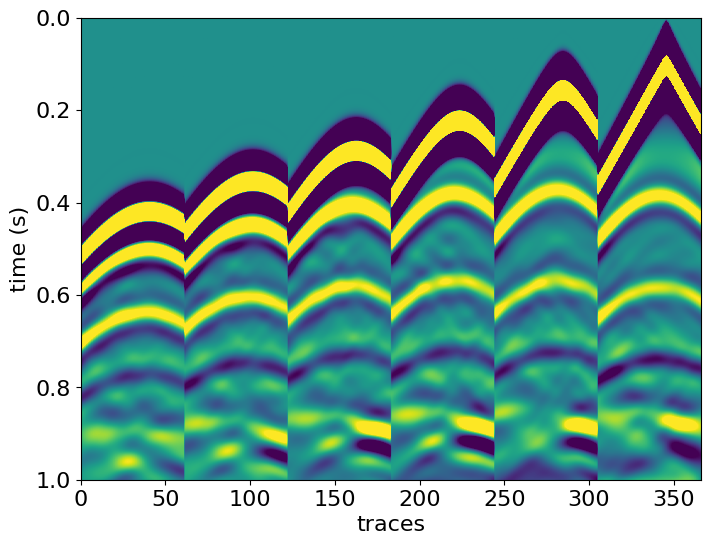

(554, 366)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Swath:  3


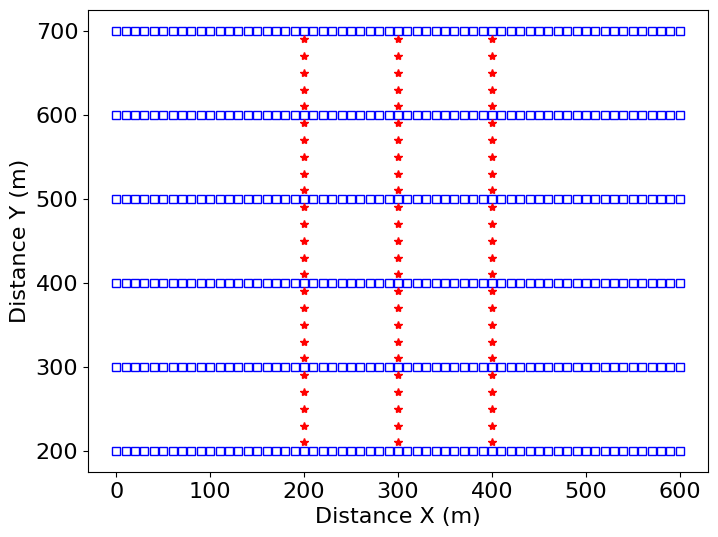

FFID:  151
200.0 210.0


Operator `Kernel` ran in 4.29 s


FFID:  152
200.0 230.0


Operator `Kernel` ran in 4.34 s


FFID:  153
200.0 250.0


Operator `Kernel` ran in 4.27 s


FFID:  154
200.0 270.0


Operator `Kernel` ran in 4.17 s


FFID:  155
200.0 290.0


Operator `Kernel` ran in 4.26 s


FFID:  156
200.0 310.0


Operator `Kernel` ran in 4.72 s


FFID:  157
200.0 330.0


Operator `Kernel` ran in 4.75 s


FFID:  158
200.0 350.0


Operator `Kernel` ran in 4.25 s


FFID:  159
200.0 370.0


Operator `Kernel` ran in 4.33 s


FFID:  160
200.0 390.0


Operator `Kernel` ran in 4.30 s


FFID:  161
200.0 410.0


Operator `Kernel` ran in 4.29 s


FFID:  162
200.0 430.0


Operator `Kernel` ran in 5.22 s


FFID:  163
200.0 450.0


Operator `Kernel` ran in 4.75 s


FFID:  164
200.0 470.0


Operator `Kernel` ran in 4.38 s


FFID:  165
200.0 490.0


Operator `Kernel` ran in 4.81 s


FFID:  166
200.0 510.0


Operator `Kernel` ran in 4.36 s


FFID:  167
200.0 530.0


Operator `Kernel` ran in 4.38 s


FFID:  168
200.0 550.0


Operator `Kernel` ran in 4.34 s


FFID:  169
200.0 570.0


Operator `Kernel` ran in 4.34 s


FFID:  170
200.0 590.0


Operator `Kernel` ran in 4.30 s


FFID:  171
200.0 610.0


Operator `Kernel` ran in 4.30 s


FFID:  172
200.0 630.0


Operator `Kernel` ran in 4.35 s


FFID:  173
200.0 650.0


Operator `Kernel` ran in 4.31 s


FFID:  174
200.0 670.0


Operator `Kernel` ran in 4.34 s


FFID:  175
200.0 690.0


Operator `Kernel` ran in 4.30 s


FFID:  176
300.0 210.0


Operator `Kernel` ran in 4.24 s


FFID:  177
300.0 230.0


Operator `Kernel` ran in 4.32 s


FFID:  178
300.0 250.0


Operator `Kernel` ran in 4.18 s


FFID:  179
300.0 270.0


Operator `Kernel` ran in 4.39 s


FFID:  180
300.0 290.0


Operator `Kernel` ran in 4.43 s


FFID:  181
300.0 310.0


Operator `Kernel` ran in 4.15 s


FFID:  182
300.0 330.0


Operator `Kernel` ran in 4.23 s


FFID:  183
300.0 350.0


Operator `Kernel` ran in 4.54 s


FFID:  184
300.0 370.0


Operator `Kernel` ran in 4.52 s


FFID:  185
300.0 390.0


Operator `Kernel` ran in 4.42 s


FFID:  186
300.0 410.0


Operator `Kernel` ran in 4.40 s


FFID:  187
300.0 430.0


Operator `Kernel` ran in 4.16 s


FFID:  188
300.0 450.0


Operator `Kernel` ran in 4.16 s


FFID:  189
300.0 470.0


Operator `Kernel` ran in 4.32 s


FFID:  190
300.0 490.0


Operator `Kernel` ran in 4.12 s


FFID:  191
300.0 510.0


Operator `Kernel` ran in 4.21 s


FFID:  192
300.0 530.0


Operator `Kernel` ran in 4.73 s


FFID:  193
300.0 550.0


Operator `Kernel` ran in 4.71 s


FFID:  194
300.0 570.0


Operator `Kernel` ran in 4.33 s


FFID:  195
300.0 590.0


Operator `Kernel` ran in 4.44 s


FFID:  196
300.0 610.0


Operator `Kernel` ran in 4.41 s


FFID:  197
300.0 630.0


Operator `Kernel` ran in 4.57 s


FFID:  198
300.0 650.0


Operator `Kernel` ran in 4.25 s


FFID:  199
300.0 670.0


Operator `Kernel` ran in 4.50 s


FFID:  200
300.0 690.0


Operator `Kernel` ran in 4.31 s


FFID:  201
400.0 210.0


Operator `Kernel` ran in 4.21 s


FFID:  202
400.0 230.0


Operator `Kernel` ran in 4.26 s


FFID:  203
400.0 250.0


Operator `Kernel` ran in 4.45 s


FFID:  204
400.0 270.0


Operator `Kernel` ran in 4.29 s


FFID:  205
400.0 290.0


Operator `Kernel` ran in 4.49 s


FFID:  206
400.0 310.0


Operator `Kernel` ran in 4.46 s


FFID:  207
400.0 330.0


Operator `Kernel` ran in 4.61 s


FFID:  208
400.0 350.0


Operator `Kernel` ran in 4.52 s


FFID:  209
400.0 370.0


Operator `Kernel` ran in 4.23 s


FFID:  210
400.0 390.0


Operator `Kernel` ran in 4.10 s


FFID:  211
400.0 410.0


Operator `Kernel` ran in 4.17 s


FFID:  212
400.0 430.0


Operator `Kernel` ran in 4.33 s


FFID:  213
400.0 450.0


Operator `Kernel` ran in 4.30 s


FFID:  214
400.0 470.0


Operator `Kernel` ran in 4.19 s


FFID:  215
400.0 490.0


Operator `Kernel` ran in 4.41 s


FFID:  216
400.0 510.0


Operator `Kernel` ran in 4.22 s


FFID:  217
400.0 530.0


Operator `Kernel` ran in 4.33 s


FFID:  218
400.0 550.0


Operator `Kernel` ran in 4.36 s


FFID:  219
400.0 570.0


Operator `Kernel` ran in 4.16 s


FFID:  220
400.0 590.0


Operator `Kernel` ran in 4.16 s


FFID:  221
400.0 610.0


Operator `Kernel` ran in 4.43 s


FFID:  222
400.0 630.0


Operator `Kernel` ran in 4.23 s


FFID:  223
400.0 650.0


Operator `Kernel` ran in 4.20 s


FFID:  224
400.0 670.0


Operator `Kernel` ran in 5.78 s


FFID:  225
400.0 690.0


Operator `Kernel` ran in 5.17 s


75


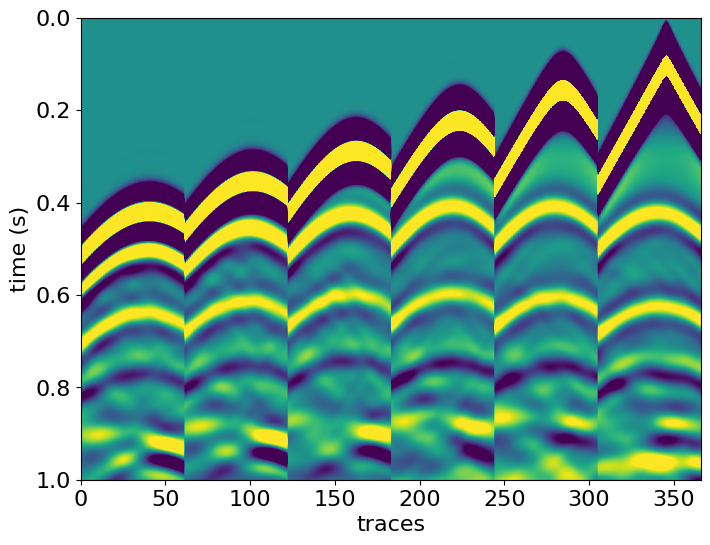

(554, 366)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Swath:  4


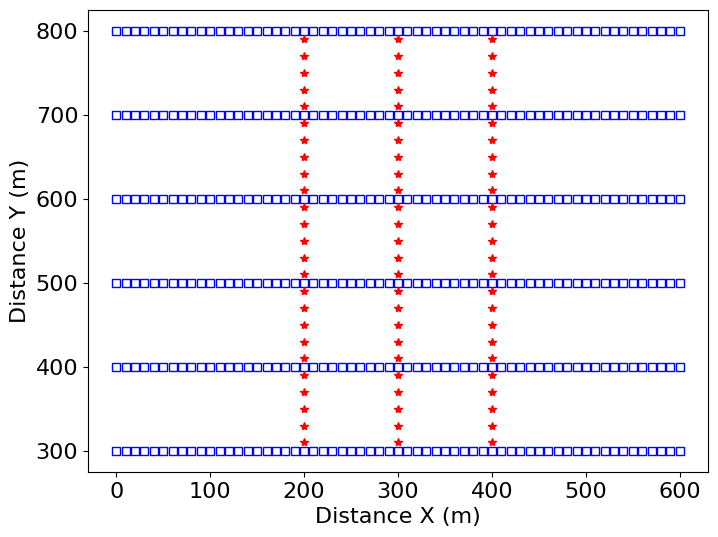

FFID:  226
200.0 310.0


Operator `Kernel` ran in 4.41 s


FFID:  227
200.0 330.0


Operator `Kernel` ran in 4.32 s


FFID:  228
200.0 350.0


Operator `Kernel` ran in 4.48 s


FFID:  229
200.0 370.0


Operator `Kernel` ran in 4.41 s


FFID:  230
200.0 390.0


Operator `Kernel` ran in 4.63 s


FFID:  231
200.0 410.0


Operator `Kernel` ran in 4.28 s


FFID:  232
200.0 430.0


Operator `Kernel` ran in 4.37 s


FFID:  233
200.0 450.0


Operator `Kernel` ran in 4.11 s


FFID:  234
200.0 470.0


Operator `Kernel` ran in 4.39 s


FFID:  235
200.0 490.0


Operator `Kernel` ran in 4.22 s


FFID:  236
200.0 510.0


Operator `Kernel` ran in 4.89 s


FFID:  237
200.0 530.0


Operator `Kernel` ran in 4.94 s


FFID:  238
200.0 550.0


Operator `Kernel` ran in 4.59 s


FFID:  239
200.0 570.0


Operator `Kernel` ran in 4.30 s


FFID:  240
200.0 590.0


Operator `Kernel` ran in 4.22 s


FFID:  241
200.0 610.0


Operator `Kernel` ran in 4.22 s


FFID:  242
200.0 630.0


Operator `Kernel` ran in 4.44 s


FFID:  243
200.0 650.0


Operator `Kernel` ran in 4.08 s


FFID:  244
200.0 670.0


Operator `Kernel` ran in 4.02 s


FFID:  245
200.0 690.0


Operator `Kernel` ran in 4.24 s


FFID:  246
200.0 710.0


Operator `Kernel` ran in 3.99 s


FFID:  247
200.0 730.0


Operator `Kernel` ran in 3.99 s


FFID:  248
200.0 750.0


Operator `Kernel` ran in 3.98 s


FFID:  249
200.0 770.0


Operator `Kernel` ran in 3.97 s


FFID:  250
200.0 790.0


Operator `Kernel` ran in 4.15 s


FFID:  251
300.0 310.0


Operator `Kernel` ran in 4.23 s


FFID:  252
300.0 330.0


Operator `Kernel` ran in 4.83 s


FFID:  253
300.0 350.0


Operator `Kernel` ran in 4.15 s


FFID:  254
300.0 370.0


Operator `Kernel` ran in 4.66 s


FFID:  255
300.0 390.0


Operator `Kernel` ran in 4.21 s


FFID:  256
300.0 410.0


Operator `Kernel` ran in 4.06 s


FFID:  257
300.0 430.0


Operator `Kernel` ran in 3.95 s


FFID:  258
300.0 450.0


Operator `Kernel` ran in 4.22 s


FFID:  259
300.0 470.0


Operator `Kernel` ran in 4.24 s


FFID:  260
300.0 490.0


Operator `Kernel` ran in 4.29 s


FFID:  261
300.0 510.0


Operator `Kernel` ran in 3.97 s


FFID:  262
300.0 530.0


Operator `Kernel` ran in 4.27 s


FFID:  263
300.0 550.0


Operator `Kernel` ran in 4.30 s


FFID:  264
300.0 570.0


Operator `Kernel` ran in 4.05 s


FFID:  265
300.0 590.0


Operator `Kernel` ran in 4.32 s


FFID:  266
300.0 610.0


Operator `Kernel` ran in 4.68 s


FFID:  267
300.0 630.0


Operator `Kernel` ran in 4.29 s


FFID:  268
300.0 650.0


Operator `Kernel` ran in 4.21 s


FFID:  269
300.0 670.0


Operator `Kernel` ran in 4.02 s


FFID:  270
300.0 690.0


Operator `Kernel` ran in 4.09 s


FFID:  271
300.0 710.0


Operator `Kernel` ran in 4.00 s


FFID:  272
300.0 730.0


Operator `Kernel` ran in 4.12 s


FFID:  273
300.0 750.0


Operator `Kernel` ran in 4.00 s


FFID:  274
300.0 770.0


Operator `Kernel` ran in 4.18 s


FFID:  275
300.0 790.0


Operator `Kernel` ran in 4.18 s


FFID:  276
400.0 310.0


Operator `Kernel` ran in 4.21 s


FFID:  277
400.0 330.0


Operator `Kernel` ran in 4.46 s


FFID:  278
400.0 350.0


Operator `Kernel` ran in 4.56 s


FFID:  279
400.0 370.0


Operator `Kernel` ran in 4.15 s


FFID:  280
400.0 390.0


Operator `Kernel` ran in 4.05 s


FFID:  281
400.0 410.0


Operator `Kernel` ran in 3.97 s


FFID:  282
400.0 430.0


Operator `Kernel` ran in 3.89 s


FFID:  283
400.0 450.0


Operator `Kernel` ran in 3.97 s


FFID:  284
400.0 470.0


Operator `Kernel` ran in 4.03 s


FFID:  285
400.0 490.0


Operator `Kernel` ran in 4.12 s


FFID:  286
400.0 510.0


Operator `Kernel` ran in 4.31 s


FFID:  287
400.0 530.0


Operator `Kernel` ran in 4.77 s


FFID:  288
400.0 550.0


Operator `Kernel` ran in 4.62 s


FFID:  289
400.0 570.0


Operator `Kernel` ran in 4.36 s


FFID:  290
400.0 590.0


Operator `Kernel` ran in 4.44 s


FFID:  291
400.0 610.0


Operator `Kernel` ran in 4.13 s


FFID:  292
400.0 630.0


Operator `Kernel` ran in 4.39 s


FFID:  293
400.0 650.0


Operator `Kernel` ran in 4.16 s


FFID:  294
400.0 670.0


Operator `Kernel` ran in 4.19 s


FFID:  295
400.0 690.0


Operator `Kernel` ran in 4.19 s


FFID:  296
400.0 710.0


Operator `Kernel` ran in 4.22 s


FFID:  297
400.0 730.0


Operator `Kernel` ran in 4.32 s


FFID:  298
400.0 750.0


Operator `Kernel` ran in 4.30 s


FFID:  299
400.0 770.0


Operator `Kernel` ran in 4.08 s


FFID:  300
400.0 790.0


Operator `Kernel` ran in 4.13 s


75


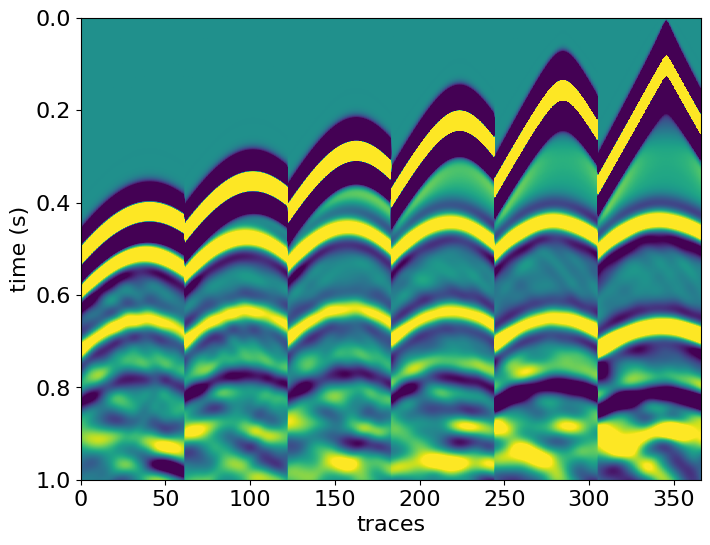

(554, 366)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Swath:  5


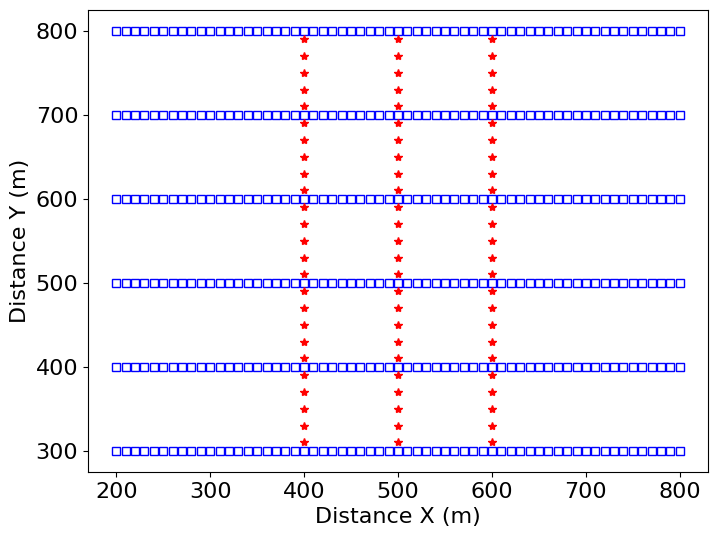

FFID:  301
400.0 310.0


Operator `Kernel` ran in 4.30 s


FFID:  302
400.0 330.0


Operator `Kernel` ran in 4.26 s


FFID:  303
400.0 350.0


Operator `Kernel` ran in 4.10 s


FFID:  304
400.0 370.0


Operator `Kernel` ran in 4.26 s


FFID:  305
400.0 390.0


Operator `Kernel` ran in 4.36 s


FFID:  306
400.0 410.0


Operator `Kernel` ran in 4.29 s


FFID:  307
400.0 430.0


Operator `Kernel` ran in 4.31 s


FFID:  308
400.0 450.0


Operator `Kernel` ran in 4.26 s


FFID:  309
400.0 470.0


Operator `Kernel` ran in 4.45 s


FFID:  310
400.0 490.0


Operator `Kernel` ran in 4.20 s


FFID:  311
400.0 510.0


Operator `Kernel` ran in 4.00 s


FFID:  312
400.0 530.0


Operator `Kernel` ran in 4.13 s


FFID:  313
400.0 550.0


Operator `Kernel` ran in 4.39 s


FFID:  314
400.0 570.0


Operator `Kernel` ran in 4.09 s


FFID:  315
400.0 590.0


Operator `Kernel` ran in 4.19 s


FFID:  316
400.0 610.0


Operator `Kernel` ran in 4.05 s


FFID:  317
400.0 630.0


Operator `Kernel` ran in 3.97 s


FFID:  318
400.0 650.0


Operator `Kernel` ran in 4.27 s


FFID:  319
400.0 670.0


Operator `Kernel` ran in 4.24 s


FFID:  320
400.0 690.0


Operator `Kernel` ran in 4.19 s


FFID:  321
400.0 710.0


Operator `Kernel` ran in 4.22 s


FFID:  322
400.0 730.0


Operator `Kernel` ran in 4.37 s


FFID:  323
400.0 750.0


Operator `Kernel` ran in 4.02 s


FFID:  324
400.0 770.0


Operator `Kernel` ran in 4.04 s


FFID:  325
400.0 790.0


Operator `Kernel` ran in 3.97 s


FFID:  326
500.0 310.0


Operator `Kernel` ran in 3.99 s


FFID:  327
500.0 330.0


Operator `Kernel` ran in 4.01 s


FFID:  328
500.0 350.0


Operator `Kernel` ran in 3.93 s


FFID:  329
500.0 370.0


Operator `Kernel` ran in 3.96 s


FFID:  330
500.0 390.0


Operator `Kernel` ran in 3.96 s


FFID:  331
500.0 410.0


Operator `Kernel` ran in 3.93 s


FFID:  332
500.0 430.0


Operator `Kernel` ran in 3.89 s


FFID:  333
500.0 450.0


Operator `Kernel` ran in 3.90 s


FFID:  334
500.0 470.0


Operator `Kernel` ran in 3.96 s


FFID:  335
500.0 490.0


Operator `Kernel` ran in 3.94 s


FFID:  336
500.0 510.0


Operator `Kernel` ran in 3.96 s


FFID:  337
500.0 530.0


Operator `Kernel` ran in 3.96 s


FFID:  338
500.0 550.0


Operator `Kernel` ran in 3.93 s


FFID:  339
500.0 570.0


Operator `Kernel` ran in 4.04 s


FFID:  340
500.0 590.0


Operator `Kernel` ran in 3.93 s


FFID:  341
500.0 610.0


Operator `Kernel` ran in 3.92 s


FFID:  342
500.0 630.0


Operator `Kernel` ran in 3.94 s


FFID:  343
500.0 650.0


Operator `Kernel` ran in 3.93 s


FFID:  344
500.0 670.0


Operator `Kernel` ran in 3.92 s


FFID:  345
500.0 690.0


Operator `Kernel` ran in 3.96 s


FFID:  346
500.0 710.0


Operator `Kernel` ran in 3.95 s


FFID:  347
500.0 730.0


Operator `Kernel` ran in 3.93 s


FFID:  348
500.0 750.0


Operator `Kernel` ran in 3.91 s


FFID:  349
500.0 770.0


Operator `Kernel` ran in 3.92 s


FFID:  350
500.0 790.0


Operator `Kernel` ran in 3.95 s


FFID:  351
600.0 310.0


Operator `Kernel` ran in 3.92 s


FFID:  352
600.0 330.0


Operator `Kernel` ran in 3.91 s


FFID:  353
600.0 350.0


Operator `Kernel` ran in 3.90 s


FFID:  354
600.0 370.0


Operator `Kernel` ran in 3.91 s


FFID:  355
600.0 390.0


Operator `Kernel` ran in 3.91 s


FFID:  356
600.0 410.0


Operator `Kernel` ran in 3.91 s


FFID:  357
600.0 430.0


Operator `Kernel` ran in 3.91 s


FFID:  358
600.0 450.0


Operator `Kernel` ran in 3.91 s


FFID:  359
600.0 470.0


Operator `Kernel` ran in 3.91 s


FFID:  360
600.0 490.0


Operator `Kernel` ran in 3.91 s


FFID:  361
600.0 510.0


Operator `Kernel` ran in 3.93 s


FFID:  362
600.0 530.0


Operator `Kernel` ran in 3.93 s


FFID:  363
600.0 550.0


Operator `Kernel` ran in 3.95 s


FFID:  364
600.0 570.0


Operator `Kernel` ran in 3.96 s


FFID:  365
600.0 590.0


Operator `Kernel` ran in 3.90 s


FFID:  366
600.0 610.0


Operator `Kernel` ran in 3.95 s


FFID:  367
600.0 630.0


Operator `Kernel` ran in 3.91 s


FFID:  368
600.0 650.0


Operator `Kernel` ran in 3.92 s


FFID:  369
600.0 670.0


Operator `Kernel` ran in 3.89 s


FFID:  370
600.0 690.0


Operator `Kernel` ran in 3.96 s


FFID:  371
600.0 710.0


Operator `Kernel` ran in 3.92 s


FFID:  372
600.0 730.0


Operator `Kernel` ran in 3.93 s


FFID:  373
600.0 750.0


Operator `Kernel` ran in 3.98 s


FFID:  374
600.0 770.0


Operator `Kernel` ran in 3.94 s


FFID:  375
600.0 790.0


Operator `Kernel` ran in 3.95 s


75


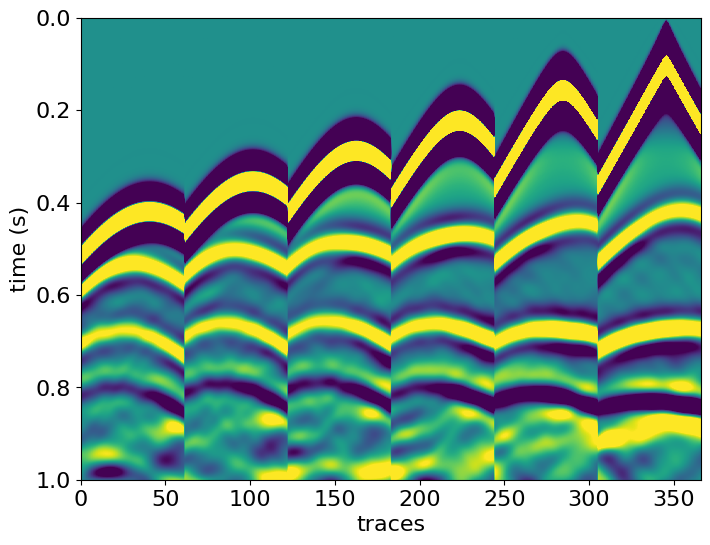

(554, 366)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Swath:  6


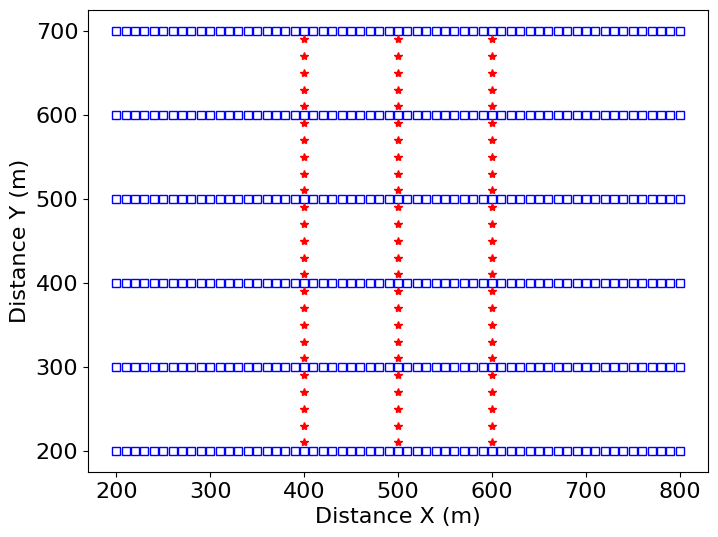

FFID:  376
400.0 210.0


Operator `Kernel` ran in 4.00 s


FFID:  377
400.0 230.0


Operator `Kernel` ran in 4.03 s


FFID:  378
400.0 250.0


Operator `Kernel` ran in 4.18 s


FFID:  379
400.0 270.0


Operator `Kernel` ran in 4.10 s


FFID:  380
400.0 290.0


Operator `Kernel` ran in 4.15 s


FFID:  381
400.0 310.0


Operator `Kernel` ran in 5.40 s


FFID:  382
400.0 330.0


Operator `Kernel` ran in 5.03 s


FFID:  383
400.0 350.0


Operator `Kernel` ran in 4.48 s


FFID:  384
400.0 370.0


Operator `Kernel` ran in 4.33 s


FFID:  385
400.0 390.0


Operator `Kernel` ran in 4.02 s


FFID:  386
400.0 410.0


Operator `Kernel` ran in 4.15 s


FFID:  387
400.0 430.0


Operator `Kernel` ran in 4.02 s


FFID:  388
400.0 450.0


Operator `Kernel` ran in 4.02 s


FFID:  389
400.0 470.0


Operator `Kernel` ran in 4.03 s


FFID:  390
400.0 490.0


Operator `Kernel` ran in 4.48 s


FFID:  391
400.0 510.0


Operator `Kernel` ran in 4.48 s


FFID:  392
400.0 530.0


Operator `Kernel` ran in 4.45 s


FFID:  393
400.0 550.0


Operator `Kernel` ran in 4.11 s


FFID:  394
400.0 570.0


Operator `Kernel` ran in 4.04 s


FFID:  395
400.0 590.0


Operator `Kernel` ran in 4.10 s


FFID:  396
400.0 610.0


Operator `Kernel` ran in 4.00 s


FFID:  397
400.0 630.0


Operator `Kernel` ran in 4.13 s


FFID:  398
400.0 650.0


Operator `Kernel` ran in 4.48 s


FFID:  399
400.0 670.0


Operator `Kernel` ran in 4.00 s


FFID:  400
400.0 690.0


Operator `Kernel` ran in 3.92 s


FFID:  401
500.0 210.0


Operator `Kernel` ran in 4.13 s


FFID:  402
500.0 230.0


Operator `Kernel` ran in 4.13 s


FFID:  403
500.0 250.0


Operator `Kernel` ran in 5.34 s


FFID:  404
500.0 270.0


Operator `Kernel` ran in 4.57 s


FFID:  405
500.0 290.0


Operator `Kernel` ran in 4.20 s


FFID:  406
500.0 310.0


Operator `Kernel` ran in 4.00 s


FFID:  407
500.0 330.0


Operator `Kernel` ran in 4.28 s


FFID:  408
500.0 350.0


Operator `Kernel` ran in 4.02 s


FFID:  409
500.0 370.0


Operator `Kernel` ran in 4.38 s


FFID:  410
500.0 390.0


Operator `Kernel` ran in 4.12 s


FFID:  411
500.0 410.0


Operator `Kernel` ran in 4.11 s


FFID:  412
500.0 430.0


Operator `Kernel` ran in 3.97 s


FFID:  413
500.0 450.0


Operator `Kernel` ran in 4.03 s


FFID:  414
500.0 470.0


Operator `Kernel` ran in 4.15 s


FFID:  415
500.0 490.0


Operator `Kernel` ran in 3.93 s


FFID:  416
500.0 510.0


Operator `Kernel` ran in 3.99 s


FFID:  417
500.0 530.0


Operator `Kernel` ran in 4.07 s


FFID:  418
500.0 550.0


Operator `Kernel` ran in 3.92 s


FFID:  419
500.0 570.0


Operator `Kernel` ran in 3.94 s


FFID:  420
500.0 590.0


Operator `Kernel` ran in 4.05 s


FFID:  421
500.0 610.0


Operator `Kernel` ran in 3.96 s


FFID:  422
500.0 630.0


Operator `Kernel` ran in 4.06 s


FFID:  423
500.0 650.0


Operator `Kernel` ran in 4.01 s


FFID:  424
500.0 670.0


Operator `Kernel` ran in 4.00 s


FFID:  425
500.0 690.0


Operator `Kernel` ran in 3.98 s


FFID:  426
600.0 210.0


Operator `Kernel` ran in 4.02 s


FFID:  427
600.0 230.0


Operator `Kernel` ran in 3.92 s


FFID:  428
600.0 250.0


Operator `Kernel` ran in 3.93 s


FFID:  429
600.0 270.0


Operator `Kernel` ran in 4.04 s


FFID:  430
600.0 290.0


Operator `Kernel` ran in 3.93 s


FFID:  431
600.0 310.0


Operator `Kernel` ran in 3.95 s


FFID:  432
600.0 330.0


Operator `Kernel` ran in 3.97 s


FFID:  433
600.0 350.0


Operator `Kernel` ran in 3.97 s


FFID:  434
600.0 370.0


Operator `Kernel` ran in 4.07 s


FFID:  435
600.0 390.0


Operator `Kernel` ran in 4.10 s


FFID:  436
600.0 410.0


Operator `Kernel` ran in 4.67 s


FFID:  437
600.0 430.0


Operator `Kernel` ran in 4.37 s


FFID:  438
600.0 450.0


Operator `Kernel` ran in 4.17 s


FFID:  439
600.0 470.0


Operator `Kernel` ran in 4.99 s


FFID:  440
600.0 490.0


Operator `Kernel` ran in 4.50 s


FFID:  441
600.0 510.0


Operator `Kernel` ran in 4.56 s


FFID:  442
600.0 530.0


Operator `Kernel` ran in 4.46 s


FFID:  443
600.0 550.0


Operator `Kernel` ran in 4.36 s


FFID:  444
600.0 570.0


Operator `Kernel` ran in 4.13 s


FFID:  445
600.0 590.0


Operator `Kernel` ran in 4.61 s


FFID:  446
600.0 610.0


Operator `Kernel` ran in 4.22 s


FFID:  447
600.0 630.0


Operator `Kernel` ran in 4.89 s


FFID:  448
600.0 650.0


Operator `Kernel` ran in 4.12 s


FFID:  449
600.0 670.0


Operator `Kernel` ran in 4.15 s


FFID:  450
600.0 690.0


Operator `Kernel` ran in 4.02 s


75


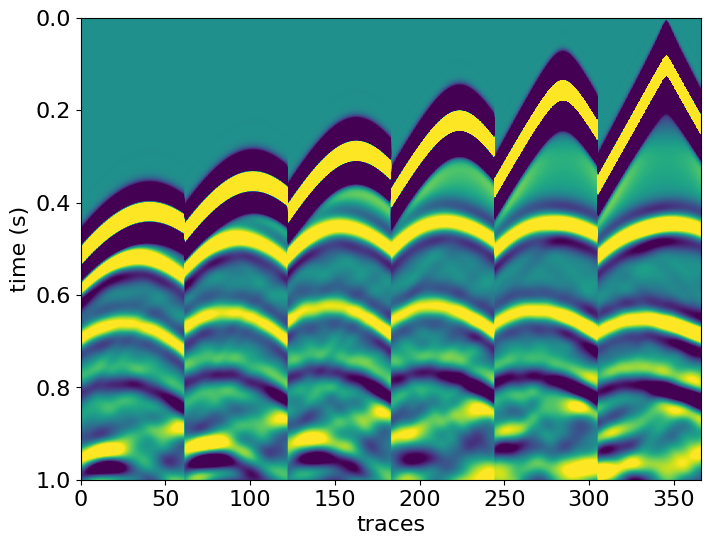

(554, 366)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Swath:  7


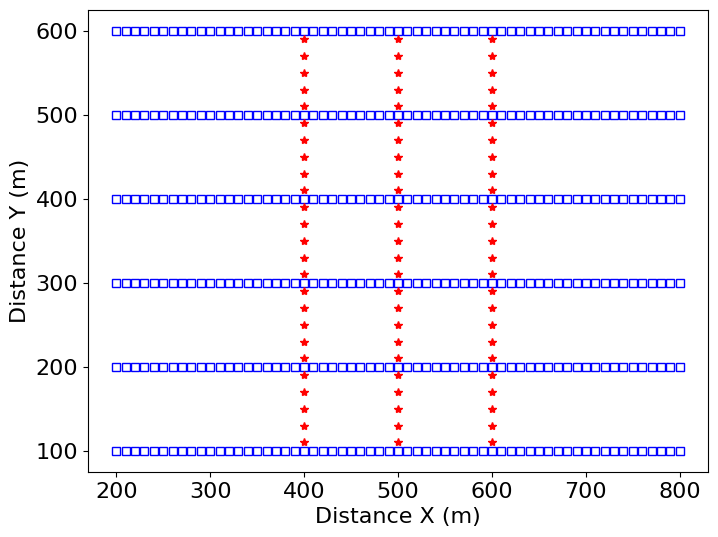

FFID:  451
400.0 110.0


Operator `Kernel` ran in 4.45 s


FFID:  452
400.0 130.0


Operator `Kernel` ran in 4.44 s


FFID:  453
400.0 150.0


Operator `Kernel` ran in 4.46 s


FFID:  454
400.0 170.0


Operator `Kernel` ran in 4.40 s


FFID:  455
400.0 190.0


Operator `Kernel` ran in 4.28 s


FFID:  456
400.0 210.0


Operator `Kernel` ran in 4.19 s


FFID:  457
400.0 230.0


Operator `Kernel` ran in 4.08 s


FFID:  458
400.0 250.0


Operator `Kernel` ran in 4.21 s


FFID:  459
400.0 270.0


Operator `Kernel` ran in 4.26 s


FFID:  460
400.0 290.0


Operator `Kernel` ran in 4.13 s


FFID:  461
400.0 310.0


Operator `Kernel` ran in 5.02 s


FFID:  462
400.0 330.0


Operator `Kernel` ran in 4.16 s


FFID:  463
400.0 350.0


Operator `Kernel` ran in 4.13 s


FFID:  464
400.0 370.0


Operator `Kernel` ran in 4.45 s


FFID:  465
400.0 390.0


Operator `Kernel` ran in 4.70 s


FFID:  466
400.0 410.0


Operator `Kernel` ran in 4.22 s


FFID:  467
400.0 430.0


Operator `Kernel` ran in 4.06 s


FFID:  468
400.0 450.0


Operator `Kernel` ran in 4.28 s


FFID:  469
400.0 470.0


Operator `Kernel` ran in 4.38 s


FFID:  470
400.0 490.0


Operator `Kernel` ran in 4.24 s


FFID:  471
400.0 510.0


Operator `Kernel` ran in 4.03 s


FFID:  472
400.0 530.0


Operator `Kernel` ran in 4.89 s


FFID:  473
400.0 550.0


Operator `Kernel` ran in 4.53 s


FFID:  474
400.0 570.0


Operator `Kernel` ran in 4.28 s


FFID:  475
400.0 590.0


Operator `Kernel` ran in 4.05 s


FFID:  476
500.0 110.0


Operator `Kernel` ran in 4.02 s


FFID:  477
500.0 130.0


Operator `Kernel` ran in 4.11 s


FFID:  478
500.0 150.0


Operator `Kernel` ran in 3.97 s


FFID:  479
500.0 170.0


Operator `Kernel` ran in 3.93 s


FFID:  480
500.0 190.0


Operator `Kernel` ran in 3.98 s


FFID:  481
500.0 210.0


Operator `Kernel` ran in 3.89 s


FFID:  482
500.0 230.0


Operator `Kernel` ran in 3.98 s


FFID:  483
500.0 250.0


Operator `Kernel` ran in 3.97 s


FFID:  484
500.0 270.0


Operator `Kernel` ran in 3.95 s


FFID:  485
500.0 290.0


Operator `Kernel` ran in 4.01 s


FFID:  486
500.0 310.0


Operator `Kernel` ran in 3.97 s


FFID:  487
500.0 330.0


Operator `Kernel` ran in 3.83 s


FFID:  488
500.0 350.0


Operator `Kernel` ran in 3.83 s


FFID:  489
500.0 370.0


Operator `Kernel` ran in 3.84 s


FFID:  490
500.0 390.0


Operator `Kernel` ran in 3.81 s


FFID:  491
500.0 410.0


Operator `Kernel` ran in 3.82 s


FFID:  492
500.0 430.0


Operator `Kernel` ran in 3.82 s


FFID:  493
500.0 450.0


Operator `Kernel` ran in 3.96 s


FFID:  494
500.0 470.0


Operator `Kernel` ran in 3.98 s


FFID:  495
500.0 490.0


Operator `Kernel` ran in 3.95 s


FFID:  496
500.0 510.0


Operator `Kernel` ran in 3.92 s


FFID:  497
500.0 530.0


Operator `Kernel` ran in 4.08 s


FFID:  498
500.0 550.0


Operator `Kernel` ran in 3.99 s


FFID:  499
500.0 570.0


Operator `Kernel` ran in 3.83 s


FFID:  500
500.0 590.0


Operator `Kernel` ran in 3.87 s


FFID:  501
600.0 110.0


Operator `Kernel` ran in 4.08 s


FFID:  502
600.0 130.0


Operator `Kernel` ran in 4.11 s


FFID:  503
600.0 150.0


Operator `Kernel` ran in 4.04 s


FFID:  504
600.0 170.0


Operator `Kernel` ran in 3.95 s


FFID:  505
600.0 190.0


Operator `Kernel` ran in 3.98 s


FFID:  506
600.0 210.0


Operator `Kernel` ran in 4.13 s


FFID:  507
600.0 230.0


Operator `Kernel` ran in 3.91 s


FFID:  508
600.0 250.0


Operator `Kernel` ran in 3.93 s


FFID:  509
600.0 270.0


Operator `Kernel` ran in 4.08 s


FFID:  510
600.0 290.0


Operator `Kernel` ran in 3.84 s


FFID:  511
600.0 310.0


Operator `Kernel` ran in 3.80 s


FFID:  512
600.0 330.0


Operator `Kernel` ran in 3.81 s


FFID:  513
600.0 350.0


Operator `Kernel` ran in 3.81 s


FFID:  514
600.0 370.0


Operator `Kernel` ran in 3.82 s


FFID:  515
600.0 390.0


Operator `Kernel` ran in 3.83 s


FFID:  516
600.0 410.0


Operator `Kernel` ran in 3.79 s


FFID:  517
600.0 430.0


Operator `Kernel` ran in 3.81 s


FFID:  518
600.0 450.0


Operator `Kernel` ran in 3.79 s


FFID:  519
600.0 470.0


Operator `Kernel` ran in 3.80 s


FFID:  520
600.0 490.0


Operator `Kernel` ran in 3.79 s


FFID:  521
600.0 510.0


Operator `Kernel` ran in 3.80 s


FFID:  522
600.0 530.0


Operator `Kernel` ran in 3.79 s


FFID:  523
600.0 550.0


Operator `Kernel` ran in 3.84 s


FFID:  524
600.0 570.0


Operator `Kernel` ran in 3.80 s


FFID:  525
600.0 590.0


Operator `Kernel` ran in 3.82 s


75


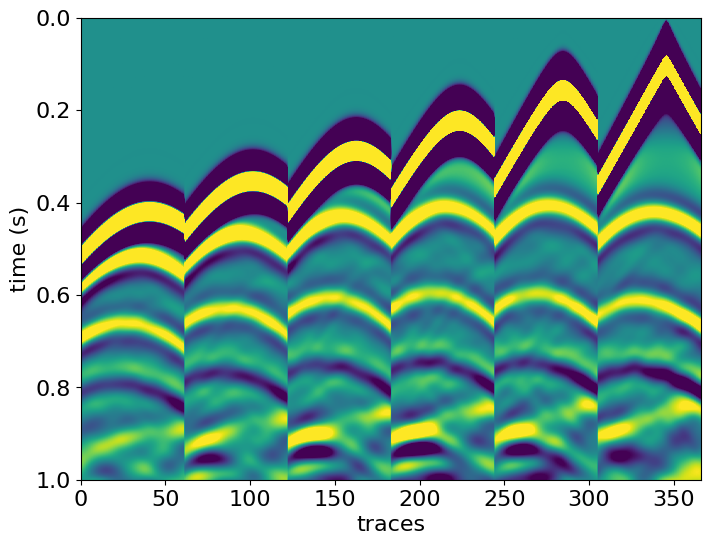

(554, 366)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Swath:  8


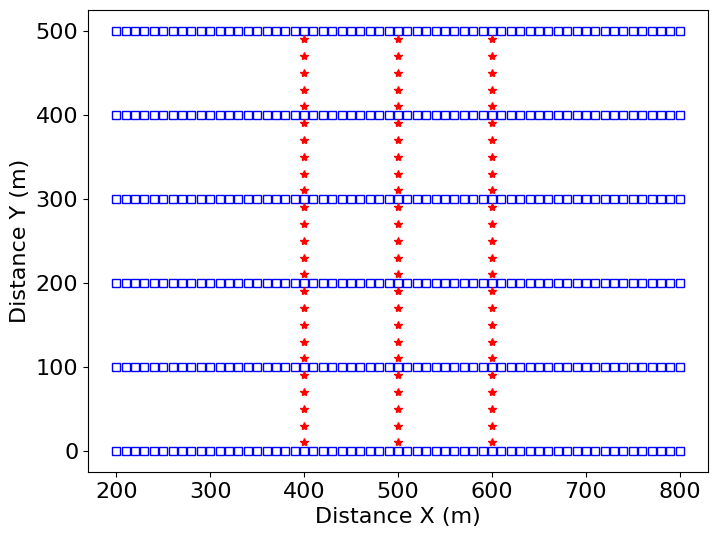

FFID:  526
400.0 10.0


Operator `Kernel` ran in 3.82 s


FFID:  527
400.0 30.0


Operator `Kernel` ran in 3.85 s


FFID:  528
400.0 50.0


Operator `Kernel` ran in 3.84 s


FFID:  529
400.0 70.0


Operator `Kernel` ran in 3.81 s


FFID:  530
400.0 90.0


Operator `Kernel` ran in 3.85 s


FFID:  531
400.0 110.0


Operator `Kernel` ran in 3.83 s


FFID:  532
400.0 130.0


Operator `Kernel` ran in 3.81 s


FFID:  533
400.0 150.0


Operator `Kernel` ran in 3.85 s


FFID:  534
400.0 170.0


Operator `Kernel` ran in 3.84 s


FFID:  535
400.0 190.0


Operator `Kernel` ran in 3.80 s


FFID:  536
400.0 210.0


Operator `Kernel` ran in 3.81 s


FFID:  537
400.0 230.0


Operator `Kernel` ran in 3.81 s


FFID:  538
400.0 250.0


Operator `Kernel` ran in 3.79 s


FFID:  539
400.0 270.0


Operator `Kernel` ran in 3.83 s


FFID:  540
400.0 290.0


Operator `Kernel` ran in 3.83 s


FFID:  541
400.0 310.0


Operator `Kernel` ran in 3.79 s


FFID:  542
400.0 330.0


Operator `Kernel` ran in 3.80 s


FFID:  543
400.0 350.0


Operator `Kernel` ran in 3.80 s


FFID:  544
400.0 370.0


Operator `Kernel` ran in 3.80 s


FFID:  545
400.0 390.0


Operator `Kernel` ran in 3.82 s


FFID:  546
400.0 410.0


Operator `Kernel` ran in 3.81 s


FFID:  547
400.0 430.0


Operator `Kernel` ran in 3.85 s


FFID:  548
400.0 450.0


Operator `Kernel` ran in 3.79 s


FFID:  549
400.0 470.0


Operator `Kernel` ran in 3.82 s


FFID:  550
400.0 490.0


Operator `Kernel` ran in 3.82 s


FFID:  551
500.0 10.0


Operator `Kernel` ran in 3.80 s


FFID:  552
500.0 30.0


Operator `Kernel` ran in 3.91 s


FFID:  553
500.0 50.0


Operator `Kernel` ran in 3.84 s


FFID:  554
500.0 70.0


Operator `Kernel` ran in 3.81 s


FFID:  555
500.0 90.0


Operator `Kernel` ran in 3.82 s


FFID:  556
500.0 110.0


Operator `Kernel` ran in 3.82 s


FFID:  557
500.0 130.0


Operator `Kernel` ran in 3.83 s


FFID:  558
500.0 150.0


Operator `Kernel` ran in 3.85 s


FFID:  559
500.0 170.0


Operator `Kernel` ran in 3.81 s


FFID:  560
500.0 190.0


Operator `Kernel` ran in 3.81 s


FFID:  561
500.0 210.0


Operator `Kernel` ran in 3.84 s


FFID:  562
500.0 230.0


Operator `Kernel` ran in 3.80 s


FFID:  563
500.0 250.0


Operator `Kernel` ran in 3.80 s


FFID:  564
500.0 270.0


Operator `Kernel` ran in 3.82 s


FFID:  565
500.0 290.0


Operator `Kernel` ran in 3.80 s


FFID:  566
500.0 310.0


Operator `Kernel` ran in 3.80 s


FFID:  567
500.0 330.0


Operator `Kernel` ran in 3.79 s


FFID:  568
500.0 350.0


Operator `Kernel` ran in 3.80 s


FFID:  569
500.0 370.0


Operator `Kernel` ran in 3.82 s


FFID:  570
500.0 390.0


Operator `Kernel` ran in 3.83 s


FFID:  571
500.0 410.0


Operator `Kernel` ran in 3.83 s


FFID:  572
500.0 430.0


Operator `Kernel` ran in 3.81 s


FFID:  573
500.0 450.0


Operator `Kernel` ran in 3.81 s


FFID:  574
500.0 470.0


Operator `Kernel` ran in 3.83 s


FFID:  575
500.0 490.0


Operator `Kernel` ran in 3.81 s


FFID:  576
600.0 10.0


Operator `Kernel` ran in 3.79 s


FFID:  577
600.0 30.0


Operator `Kernel` ran in 3.81 s


FFID:  578
600.0 50.0


Operator `Kernel` ran in 3.91 s


FFID:  579
600.0 70.0


Operator `Kernel` ran in 3.81 s


FFID:  580
600.0 90.0


Operator `Kernel` ran in 3.82 s


FFID:  581
600.0 110.0


Operator `Kernel` ran in 3.81 s


FFID:  582
600.0 130.0


Operator `Kernel` ran in 3.79 s


FFID:  583
600.0 150.0


Operator `Kernel` ran in 3.80 s


FFID:  584
600.0 170.0


Operator `Kernel` ran in 3.80 s


FFID:  585
600.0 190.0


Operator `Kernel` ran in 3.79 s


FFID:  586
600.0 210.0


Operator `Kernel` ran in 3.81 s


FFID:  587
600.0 230.0


Operator `Kernel` ran in 3.83 s


FFID:  588
600.0 250.0


Operator `Kernel` ran in 3.79 s


FFID:  589
600.0 270.0


Operator `Kernel` ran in 3.93 s


FFID:  590
600.0 290.0


Operator `Kernel` ran in 3.82 s


FFID:  591
600.0 310.0


Operator `Kernel` ran in 3.79 s


FFID:  592
600.0 330.0


Operator `Kernel` ran in 3.84 s


FFID:  593
600.0 350.0


Operator `Kernel` ran in 3.82 s


FFID:  594
600.0 370.0


Operator `Kernel` ran in 3.81 s


FFID:  595
600.0 390.0


Operator `Kernel` ran in 3.83 s


FFID:  596
600.0 410.0


Operator `Kernel` ran in 3.79 s


FFID:  597
600.0 430.0


Operator `Kernel` ran in 3.84 s


FFID:  598
600.0 450.0


Operator `Kernel` ran in 3.82 s


FFID:  599
600.0 470.0


Operator `Kernel` ran in 3.82 s


FFID:  600
600.0 490.0


Operator `Kernel` ran in 3.84 s


75


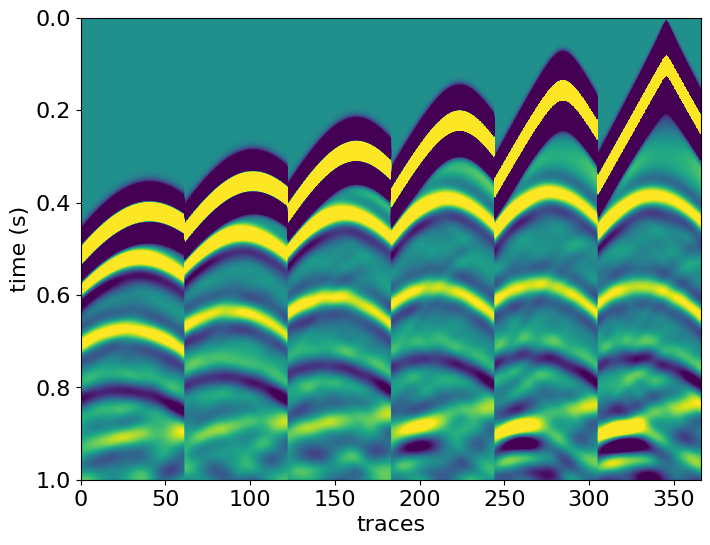

(554, 366)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Swath:  9


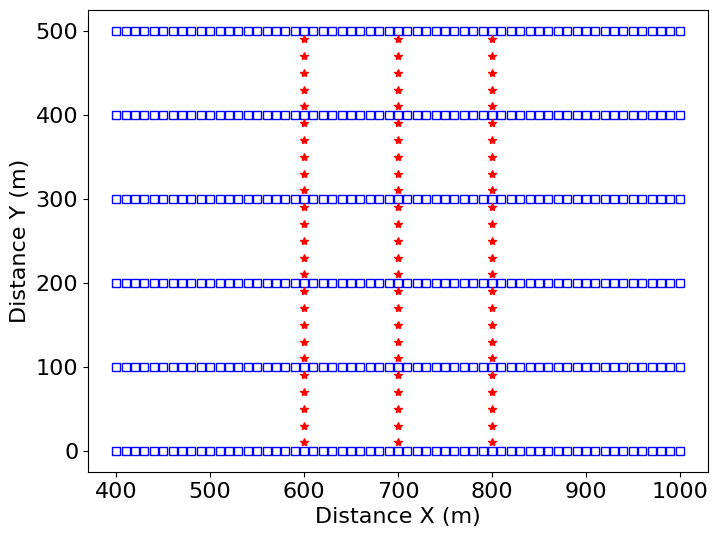

FFID:  601
600.0 10.0


Operator `Kernel` ran in 3.81 s


FFID:  602
600.0 30.0


Operator `Kernel` ran in 3.85 s


FFID:  603
600.0 50.0


Operator `Kernel` ran in 3.84 s


FFID:  604
600.0 70.0


Operator `Kernel` ran in 3.82 s


FFID:  605
600.0 90.0


Operator `Kernel` ran in 3.82 s


FFID:  606
600.0 110.0


Operator `Kernel` ran in 3.82 s


FFID:  607
600.0 130.0


Operator `Kernel` ran in 3.81 s


FFID:  608
600.0 150.0


Operator `Kernel` ran in 3.82 s


FFID:  609
600.0 170.0


Operator `Kernel` ran in 3.79 s


FFID:  610
600.0 190.0


Operator `Kernel` ran in 3.84 s


FFID:  611
600.0 210.0


Operator `Kernel` ran in 3.82 s


FFID:  612
600.0 230.0


Operator `Kernel` ran in 3.79 s


FFID:  613
600.0 250.0


Operator `Kernel` ran in 3.81 s


FFID:  614
600.0 270.0


Operator `Kernel` ran in 3.82 s


FFID:  615
600.0 290.0


Operator `Kernel` ran in 3.79 s


FFID:  616
600.0 310.0


Operator `Kernel` ran in 3.81 s


FFID:  617
600.0 330.0


Operator `Kernel` ran in 3.79 s


FFID:  618
600.0 350.0


Operator `Kernel` ran in 3.81 s


FFID:  619
600.0 370.0


Operator `Kernel` ran in 3.83 s


FFID:  620
600.0 390.0


Operator `Kernel` ran in 3.80 s


FFID:  621
600.0 410.0


Operator `Kernel` ran in 3.81 s


FFID:  622
600.0 430.0


Operator `Kernel` ran in 3.81 s


FFID:  623
600.0 450.0


Operator `Kernel` ran in 3.81 s


FFID:  624
600.0 470.0


Operator `Kernel` ran in 3.81 s


FFID:  625
600.0 490.0


Operator `Kernel` ran in 3.80 s


FFID:  626
700.0 10.0


Operator `Kernel` ran in 3.79 s


FFID:  627
700.0 30.0


Operator `Kernel` ran in 3.85 s


FFID:  628
700.0 50.0


Operator `Kernel` ran in 3.82 s


FFID:  629
700.0 70.0


Operator `Kernel` ran in 3.86 s


FFID:  630
700.0 90.0


Operator `Kernel` ran in 3.86 s


FFID:  631
700.0 110.0


Operator `Kernel` ran in 3.81 s


FFID:  632
700.0 130.0


Operator `Kernel` ran in 3.83 s


FFID:  633
700.0 150.0


Operator `Kernel` ran in 3.84 s


FFID:  634
700.0 170.0


Operator `Kernel` ran in 3.82 s


FFID:  635
700.0 190.0


Operator `Kernel` ran in 3.83 s


FFID:  636
700.0 210.0


Operator `Kernel` ran in 3.85 s


FFID:  637
700.0 230.0


Operator `Kernel` ran in 3.84 s


FFID:  638
700.0 250.0


Operator `Kernel` ran in 3.80 s


FFID:  639
700.0 270.0


Operator `Kernel` ran in 3.84 s


FFID:  640
700.0 290.0


Operator `Kernel` ran in 3.80 s


FFID:  641
700.0 310.0


Operator `Kernel` ran in 3.82 s


FFID:  642
700.0 330.0


Operator `Kernel` ran in 3.79 s


FFID:  643
700.0 350.0


Operator `Kernel` ran in 3.81 s


FFID:  644
700.0 370.0


Operator `Kernel` ran in 3.80 s


FFID:  645
700.0 390.0


Operator `Kernel` ran in 3.81 s


FFID:  646
700.0 410.0


Operator `Kernel` ran in 3.81 s


FFID:  647
700.0 430.0


Operator `Kernel` ran in 3.84 s


FFID:  648
700.0 450.0


Operator `Kernel` ran in 3.80 s


FFID:  649
700.0 470.0


Operator `Kernel` ran in 3.83 s


FFID:  650
700.0 490.0


Operator `Kernel` ran in 3.81 s


FFID:  651
800.0 10.0


Operator `Kernel` ran in 3.87 s


FFID:  652
800.0 30.0


Operator `Kernel` ran in 3.84 s


FFID:  653
800.0 50.0


Operator `Kernel` ran in 3.80 s


FFID:  654
800.0 70.0


Operator `Kernel` ran in 3.82 s


FFID:  655
800.0 90.0


Operator `Kernel` ran in 3.84 s


FFID:  656
800.0 110.0


Operator `Kernel` ran in 3.82 s


FFID:  657
800.0 130.0


Operator `Kernel` ran in 3.82 s


FFID:  658
800.0 150.0


Operator `Kernel` ran in 3.83 s


FFID:  659
800.0 170.0


Operator `Kernel` ran in 3.83 s


FFID:  660
800.0 190.0


Operator `Kernel` ran in 3.81 s


FFID:  661
800.0 210.0


Operator `Kernel` ran in 3.83 s


FFID:  662
800.0 230.0


Operator `Kernel` ran in 3.87 s


FFID:  663
800.0 250.0


Operator `Kernel` ran in 3.86 s


FFID:  664
800.0 270.0


Operator `Kernel` ran in 3.83 s


FFID:  665
800.0 290.0


Operator `Kernel` ran in 3.82 s


FFID:  666
800.0 310.0


Operator `Kernel` ran in 3.86 s


FFID:  667
800.0 330.0


Operator `Kernel` ran in 3.86 s


FFID:  668
800.0 350.0


Operator `Kernel` ran in 3.80 s


FFID:  669
800.0 370.0


Operator `Kernel` ran in 3.82 s


FFID:  670
800.0 390.0


Operator `Kernel` ran in 3.82 s


FFID:  671
800.0 410.0


Operator `Kernel` ran in 3.80 s


FFID:  672
800.0 430.0


Operator `Kernel` ran in 3.80 s


FFID:  673
800.0 450.0


Operator `Kernel` ran in 3.81 s


FFID:  674
800.0 470.0


Operator `Kernel` ran in 3.84 s


FFID:  675
800.0 490.0


Operator `Kernel` ran in 3.82 s


75


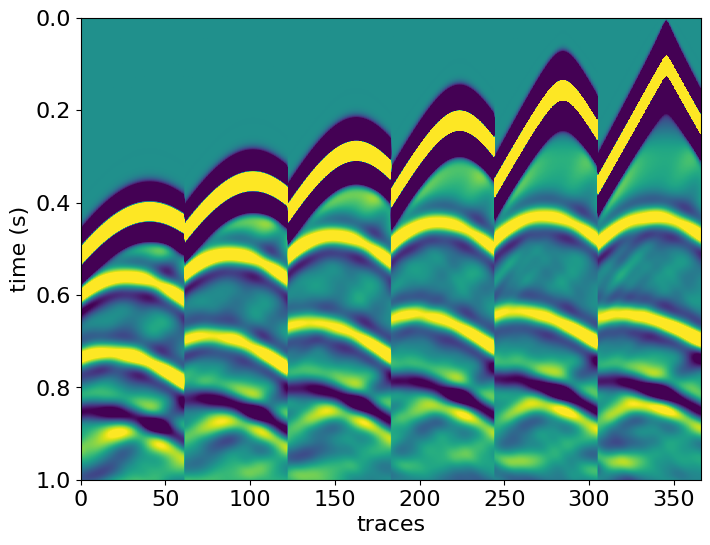

(554, 366)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Swath:  10


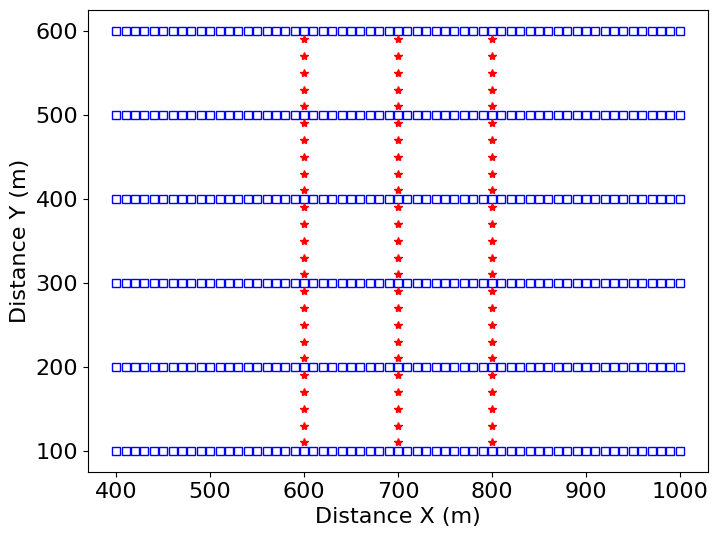

FFID:  676
600.0 110.0


Operator `Kernel` ran in 3.80 s


FFID:  677
600.0 130.0


Operator `Kernel` ran in 3.85 s


FFID:  678
600.0 150.0


Operator `Kernel` ran in 3.80 s


FFID:  679
600.0 170.0


Operator `Kernel` ran in 3.82 s


FFID:  680
600.0 190.0


Operator `Kernel` ran in 3.80 s


FFID:  681
600.0 210.0


Operator `Kernel` ran in 3.79 s


FFID:  682
600.0 230.0


Operator `Kernel` ran in 3.83 s


FFID:  683
600.0 250.0


Operator `Kernel` ran in 3.80 s


FFID:  684
600.0 270.0


Operator `Kernel` ran in 3.85 s


FFID:  685
600.0 290.0


Operator `Kernel` ran in 3.81 s


FFID:  686
600.0 310.0


Operator `Kernel` ran in 3.79 s


FFID:  687
600.0 330.0


Operator `Kernel` ran in 3.80 s


FFID:  688
600.0 350.0


Operator `Kernel` ran in 3.80 s


FFID:  689
600.0 370.0


Operator `Kernel` ran in 3.82 s


FFID:  690
600.0 390.0


Operator `Kernel` ran in 3.80 s


FFID:  691
600.0 410.0


Operator `Kernel` ran in 3.84 s


FFID:  692
600.0 430.0


Operator `Kernel` ran in 3.81 s


FFID:  693
600.0 450.0


Operator `Kernel` ran in 3.86 s


FFID:  694
600.0 470.0


Operator `Kernel` ran in 3.82 s


FFID:  695
600.0 490.0


Operator `Kernel` ran in 3.83 s


FFID:  696
600.0 510.0


Operator `Kernel` ran in 3.86 s


FFID:  697
600.0 530.0


Operator `Kernel` ran in 3.82 s


FFID:  698
600.0 550.0


Operator `Kernel` ran in 3.80 s


FFID:  699
600.0 570.0


Operator `Kernel` ran in 3.82 s


FFID:  700
600.0 590.0


Operator `Kernel` ran in 3.81 s


FFID:  701
700.0 110.0


Operator `Kernel` ran in 3.79 s


FFID:  702
700.0 130.0


Operator `Kernel` ran in 3.81 s


FFID:  703
700.0 150.0


Operator `Kernel` ran in 3.82 s


FFID:  704
700.0 170.0


Operator `Kernel` ran in 3.82 s


FFID:  705
700.0 190.0


Operator `Kernel` ran in 3.81 s


FFID:  706
700.0 210.0


Operator `Kernel` ran in 3.83 s


FFID:  707
700.0 230.0


Operator `Kernel` ran in 3.81 s


FFID:  708
700.0 250.0


Operator `Kernel` ran in 3.81 s


FFID:  709
700.0 270.0


Operator `Kernel` ran in 3.80 s


FFID:  710
700.0 290.0


Operator `Kernel` ran in 3.82 s


FFID:  711
700.0 310.0


Operator `Kernel` ran in 3.80 s


FFID:  712
700.0 330.0


Operator `Kernel` ran in 3.84 s


FFID:  713
700.0 350.0


Operator `Kernel` ran in 3.81 s


FFID:  714
700.0 370.0


Operator `Kernel` ran in 3.83 s


FFID:  715
700.0 390.0


Operator `Kernel` ran in 3.82 s


FFID:  716
700.0 410.0


Operator `Kernel` ran in 3.81 s


FFID:  717
700.0 430.0


Operator `Kernel` ran in 3.80 s


FFID:  718
700.0 450.0


Operator `Kernel` ran in 3.88 s


FFID:  719
700.0 470.0


Operator `Kernel` ran in 3.88 s


FFID:  720
700.0 490.0


Operator `Kernel` ran in 3.84 s


FFID:  721
700.0 510.0


Operator `Kernel` ran in 3.85 s


FFID:  722
700.0 530.0


Operator `Kernel` ran in 3.82 s


FFID:  723
700.0 550.0


Operator `Kernel` ran in 3.82 s


FFID:  724
700.0 570.0


Operator `Kernel` ran in 3.82 s


FFID:  725
700.0 590.0


Operator `Kernel` ran in 3.81 s


FFID:  726
800.0 110.0


Operator `Kernel` ran in 3.81 s


FFID:  727
800.0 130.0


Operator `Kernel` ran in 3.82 s


FFID:  728
800.0 150.0


Operator `Kernel` ran in 3.82 s


FFID:  729
800.0 170.0


Operator `Kernel` ran in 3.84 s


FFID:  730
800.0 190.0


Operator `Kernel` ran in 3.83 s


FFID:  731
800.0 210.0


Operator `Kernel` ran in 3.80 s


FFID:  732
800.0 230.0


Operator `Kernel` ran in 3.79 s


FFID:  733
800.0 250.0


Operator `Kernel` ran in 3.79 s


FFID:  734
800.0 270.0


Operator `Kernel` ran in 3.79 s


FFID:  735
800.0 290.0


Operator `Kernel` ran in 3.79 s


FFID:  736
800.0 310.0


Operator `Kernel` ran in 3.82 s


FFID:  737
800.0 330.0


Operator `Kernel` ran in 3.84 s


FFID:  738
800.0 350.0


Operator `Kernel` ran in 3.82 s


FFID:  739
800.0 370.0


Operator `Kernel` ran in 3.78 s


FFID:  740
800.0 390.0


Operator `Kernel` ran in 3.81 s


FFID:  741
800.0 410.0


Operator `Kernel` ran in 3.80 s


FFID:  742
800.0 430.0


Operator `Kernel` ran in 3.82 s


FFID:  743
800.0 450.0


Operator `Kernel` ran in 3.80 s


FFID:  744
800.0 470.0


Operator `Kernel` ran in 3.83 s


FFID:  745
800.0 490.0


Operator `Kernel` ran in 3.81 s


FFID:  746
800.0 510.0


Operator `Kernel` ran in 3.85 s


FFID:  747
800.0 530.0


Operator `Kernel` ran in 3.81 s


FFID:  748
800.0 550.0


Operator `Kernel` ran in 3.82 s


FFID:  749
800.0 570.0


Operator `Kernel` ran in 3.85 s


FFID:  750
800.0 590.0


Operator `Kernel` ran in 3.84 s


75


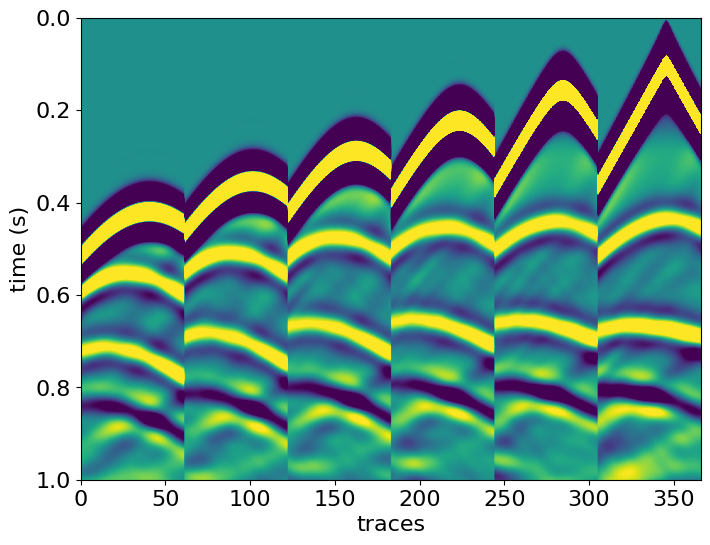

(554, 366)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Swath:  11


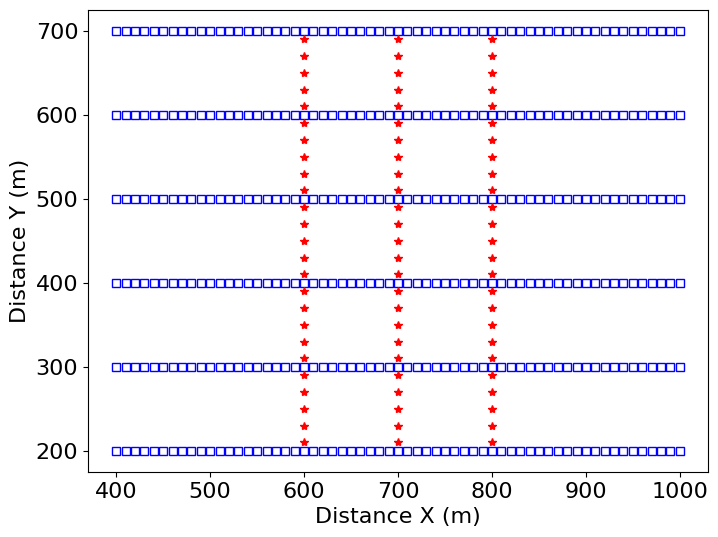

FFID:  751
600.0 210.0


Operator `Kernel` ran in 3.82 s


FFID:  752
600.0 230.0


Operator `Kernel` ran in 3.83 s


FFID:  753
600.0 250.0


Operator `Kernel` ran in 3.83 s


FFID:  754
600.0 270.0


Operator `Kernel` ran in 3.84 s


FFID:  755
600.0 290.0


Operator `Kernel` ran in 3.82 s


FFID:  756
600.0 310.0


Operator `Kernel` ran in 3.86 s


FFID:  757
600.0 330.0


Operator `Kernel` ran in 3.81 s


FFID:  758
600.0 350.0


Operator `Kernel` ran in 3.80 s


FFID:  759
600.0 370.0


Operator `Kernel` ran in 3.83 s


FFID:  760
600.0 390.0


Operator `Kernel` ran in 3.82 s


FFID:  761
600.0 410.0


Operator `Kernel` ran in 3.83 s


FFID:  762
600.0 430.0


Operator `Kernel` ran in 3.84 s


FFID:  763
600.0 450.0


Operator `Kernel` ran in 3.82 s


FFID:  764
600.0 470.0


Operator `Kernel` ran in 3.82 s


FFID:  765
600.0 490.0


Operator `Kernel` ran in 3.81 s


FFID:  766
600.0 510.0


Operator `Kernel` ran in 3.80 s


FFID:  767
600.0 530.0


Operator `Kernel` ran in 3.81 s


FFID:  768
600.0 550.0


Operator `Kernel` ran in 3.83 s


FFID:  769
600.0 570.0


Operator `Kernel` ran in 3.80 s


FFID:  770
600.0 590.0


Operator `Kernel` ran in 3.83 s


FFID:  771
600.0 610.0


Operator `Kernel` ran in 3.82 s


FFID:  772
600.0 630.0


Operator `Kernel` ran in 3.80 s


FFID:  773
600.0 650.0


Operator `Kernel` ran in 3.83 s


FFID:  774
600.0 670.0


Operator `Kernel` ran in 3.81 s


FFID:  775
600.0 690.0


Operator `Kernel` ran in 3.82 s


FFID:  776
700.0 210.0


Operator `Kernel` ran in 3.84 s


FFID:  777
700.0 230.0


Operator `Kernel` ran in 3.79 s


FFID:  778
700.0 250.0


Operator `Kernel` ran in 3.79 s


FFID:  779
700.0 270.0


Operator `Kernel` ran in 3.82 s


FFID:  780
700.0 290.0


Operator `Kernel` ran in 3.79 s


FFID:  781
700.0 310.0


Operator `Kernel` ran in 3.80 s


FFID:  782
700.0 330.0


Operator `Kernel` ran in 3.80 s


FFID:  783
700.0 350.0


Operator `Kernel` ran in 3.82 s


FFID:  784
700.0 370.0


Operator `Kernel` ran in 3.81 s


FFID:  785
700.0 390.0


Operator `Kernel` ran in 3.79 s


FFID:  786
700.0 410.0


Operator `Kernel` ran in 3.80 s


FFID:  787
700.0 430.0


Operator `Kernel` ran in 3.81 s


FFID:  788
700.0 450.0


Operator `Kernel` ran in 3.80 s


FFID:  789
700.0 470.0


Operator `Kernel` ran in 3.85 s


FFID:  790
700.0 490.0


Operator `Kernel` ran in 3.87 s


FFID:  791
700.0 510.0


Operator `Kernel` ran in 3.84 s


FFID:  792
700.0 530.0


Operator `Kernel` ran in 3.83 s


FFID:  793
700.0 550.0


Operator `Kernel` ran in 3.85 s


FFID:  794
700.0 570.0


Operator `Kernel` ran in 3.83 s


FFID:  795
700.0 590.0


Operator `Kernel` ran in 3.82 s


FFID:  796
700.0 610.0


Operator `Kernel` ran in 3.81 s


FFID:  797
700.0 630.0


Operator `Kernel` ran in 3.80 s


FFID:  798
700.0 650.0


Operator `Kernel` ran in 3.82 s


FFID:  799
700.0 670.0


Operator `Kernel` ran in 3.81 s


FFID:  800
700.0 690.0


Operator `Kernel` ran in 3.79 s


FFID:  801
800.0 210.0


Operator `Kernel` ran in 3.82 s


FFID:  802
800.0 230.0


Operator `Kernel` ran in 3.81 s


FFID:  803
800.0 250.0


Operator `Kernel` ran in 3.81 s


FFID:  804
800.0 270.0


Operator `Kernel` ran in 3.81 s


FFID:  805
800.0 290.0


Operator `Kernel` ran in 3.82 s


FFID:  806
800.0 310.0


Operator `Kernel` ran in 3.84 s


FFID:  807
800.0 330.0


Operator `Kernel` ran in 3.80 s


FFID:  808
800.0 350.0


Operator `Kernel` ran in 3.81 s


FFID:  809
800.0 370.0


Operator `Kernel` ran in 3.84 s


FFID:  810
800.0 390.0


Operator `Kernel` ran in 3.80 s


FFID:  811
800.0 410.0


Operator `Kernel` ran in 3.84 s


FFID:  812
800.0 430.0


Operator `Kernel` ran in 3.85 s


FFID:  813
800.0 450.0


Operator `Kernel` ran in 3.80 s


FFID:  814
800.0 470.0


Operator `Kernel` ran in 3.80 s


FFID:  815
800.0 490.0


Operator `Kernel` ran in 3.79 s


FFID:  816
800.0 510.0


Operator `Kernel` ran in 3.81 s


FFID:  817
800.0 530.0


Operator `Kernel` ran in 3.81 s


FFID:  818
800.0 550.0


Operator `Kernel` ran in 3.79 s


FFID:  819
800.0 570.0


Operator `Kernel` ran in 3.81 s


FFID:  820
800.0 590.0


Operator `Kernel` ran in 3.84 s


FFID:  821
800.0 610.0


Operator `Kernel` ran in 3.84 s


FFID:  822
800.0 630.0


Operator `Kernel` ran in 3.84 s


FFID:  823
800.0 650.0


Operator `Kernel` ran in 3.82 s


FFID:  824
800.0 670.0


Operator `Kernel` ran in 3.81 s


FFID:  825
800.0 690.0


Operator `Kernel` ran in 3.82 s


75


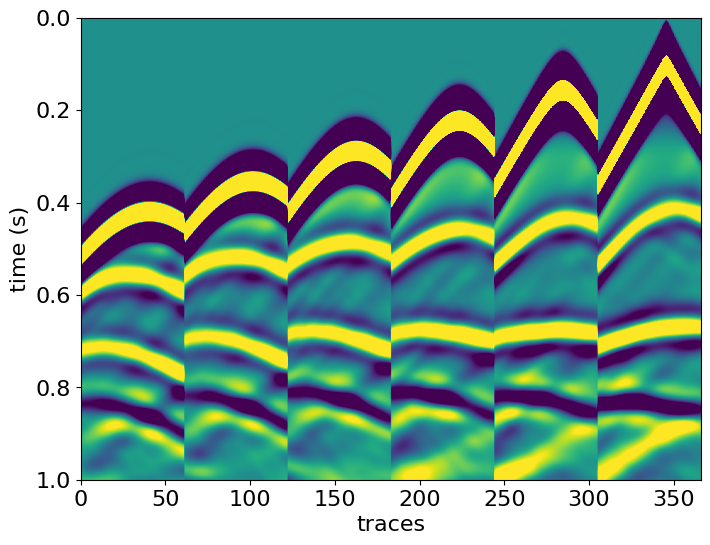

(554, 366)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Swath:  12


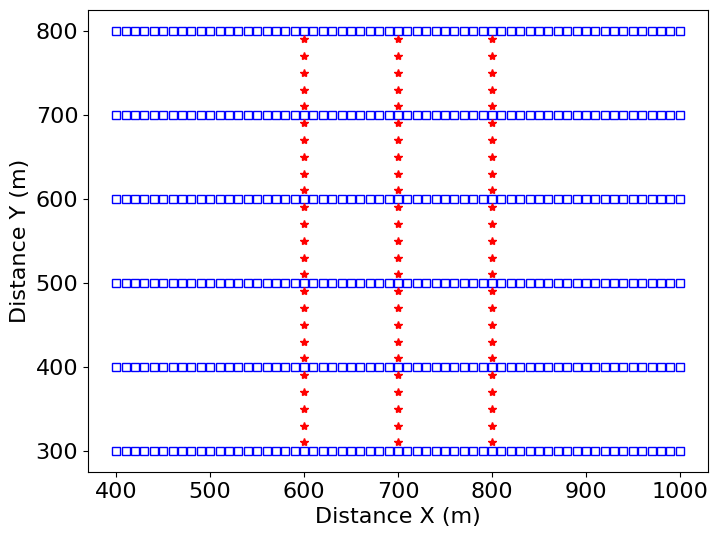

FFID:  826
600.0 310.0


Operator `Kernel` ran in 3.81 s


FFID:  827
600.0 330.0


Operator `Kernel` ran in 3.80 s


FFID:  828
600.0 350.0


Operator `Kernel` ran in 3.81 s


FFID:  829
600.0 370.0


Operator `Kernel` ran in 3.80 s


FFID:  830
600.0 390.0


Operator `Kernel` ran in 3.80 s


FFID:  831
600.0 410.0


Operator `Kernel` ran in 3.81 s


FFID:  832
600.0 430.0


Operator `Kernel` ran in 3.80 s


FFID:  833
600.0 450.0


Operator `Kernel` ran in 3.82 s


FFID:  834
600.0 470.0


Operator `Kernel` ran in 3.82 s


FFID:  835
600.0 490.0


Operator `Kernel` ran in 3.81 s


FFID:  836
600.0 510.0


Operator `Kernel` ran in 3.80 s


FFID:  837
600.0 530.0


Operator `Kernel` ran in 3.79 s


FFID:  838
600.0 550.0


Operator `Kernel` ran in 3.82 s


FFID:  839
600.0 570.0


Operator `Kernel` ran in 3.83 s


FFID:  840
600.0 590.0


Operator `Kernel` ran in 3.81 s


FFID:  841
600.0 610.0


Operator `Kernel` ran in 3.85 s


FFID:  842
600.0 630.0


Operator `Kernel` ran in 3.81 s


FFID:  843
600.0 650.0


Operator `Kernel` ran in 3.81 s


FFID:  844
600.0 670.0


Operator `Kernel` ran in 3.82 s


FFID:  845
600.0 690.0


Operator `Kernel` ran in 3.81 s


FFID:  846
600.0 710.0


Operator `Kernel` ran in 3.81 s


FFID:  847
600.0 730.0


Operator `Kernel` ran in 3.81 s


FFID:  848
600.0 750.0


Operator `Kernel` ran in 3.79 s


FFID:  849
600.0 770.0


Operator `Kernel` ran in 3.81 s


FFID:  850
600.0 790.0


Operator `Kernel` ran in 3.83 s


FFID:  851
700.0 310.0


Operator `Kernel` ran in 3.80 s


FFID:  852
700.0 330.0


Operator `Kernel` ran in 3.80 s


FFID:  853
700.0 350.0


Operator `Kernel` ran in 3.84 s


FFID:  854
700.0 370.0


Operator `Kernel` ran in 3.82 s


FFID:  855
700.0 390.0


Operator `Kernel` ran in 3.82 s


FFID:  856
700.0 410.0


Operator `Kernel` ran in 3.80 s


FFID:  857
700.0 430.0


Operator `Kernel` ran in 3.82 s


FFID:  858
700.0 450.0


Operator `Kernel` ran in 3.83 s


FFID:  859
700.0 470.0


Operator `Kernel` ran in 3.79 s


FFID:  860
700.0 490.0


Operator `Kernel` ran in 3.88 s


FFID:  861
700.0 510.0


Operator `Kernel` ran in 3.84 s


FFID:  862
700.0 530.0


Operator `Kernel` ran in 3.85 s


FFID:  863
700.0 550.0


Operator `Kernel` ran in 3.83 s


FFID:  864
700.0 570.0


Operator `Kernel` ran in 3.80 s


FFID:  865
700.0 590.0


Operator `Kernel` ran in 3.81 s


FFID:  866
700.0 610.0


Operator `Kernel` ran in 3.81 s


FFID:  867
700.0 630.0


Operator `Kernel` ran in 3.80 s


FFID:  868
700.0 650.0


Operator `Kernel` ran in 3.81 s


FFID:  869
700.0 670.0


Operator `Kernel` ran in 3.83 s


FFID:  870
700.0 690.0


Operator `Kernel` ran in 3.82 s


FFID:  871
700.0 710.0


Operator `Kernel` ran in 3.95 s


FFID:  872
700.0 730.0


Operator `Kernel` ran in 3.88 s


FFID:  873
700.0 750.0


Operator `Kernel` ran in 3.83 s


FFID:  874
700.0 770.0


Operator `Kernel` ran in 3.85 s


FFID:  875
700.0 790.0


Operator `Kernel` ran in 3.84 s


FFID:  876
800.0 310.0


Operator `Kernel` ran in 3.84 s


FFID:  877
800.0 330.0


Operator `Kernel` ran in 3.83 s


FFID:  878
800.0 350.0


Operator `Kernel` ran in 3.83 s


FFID:  879
800.0 370.0


Operator `Kernel` ran in 3.83 s


FFID:  880
800.0 390.0


Operator `Kernel` ran in 3.83 s


FFID:  881
800.0 410.0


Operator `Kernel` ran in 3.81 s


FFID:  882
800.0 430.0


Operator `Kernel` ran in 3.82 s


FFID:  883
800.0 450.0


Operator `Kernel` ran in 3.83 s


FFID:  884
800.0 470.0


Operator `Kernel` ran in 3.85 s


FFID:  885
800.0 490.0


Operator `Kernel` ran in 3.82 s


FFID:  886
800.0 510.0


Operator `Kernel` ran in 3.83 s


FFID:  887
800.0 530.0


Operator `Kernel` ran in 3.87 s


FFID:  888
800.0 550.0


Operator `Kernel` ran in 3.82 s


FFID:  889
800.0 570.0


Operator `Kernel` ran in 3.82 s


FFID:  890
800.0 590.0


Operator `Kernel` ran in 3.80 s


FFID:  891
800.0 610.0


Operator `Kernel` ran in 3.84 s


FFID:  892
800.0 630.0


Operator `Kernel` ran in 3.88 s


FFID:  893
800.0 650.0


Operator `Kernel` ran in 3.81 s


FFID:  894
800.0 670.0


Operator `Kernel` ran in 3.83 s


FFID:  895
800.0 690.0


Operator `Kernel` ran in 3.83 s


FFID:  896
800.0 710.0


Operator `Kernel` ran in 3.83 s


FFID:  897
800.0 730.0


Operator `Kernel` ran in 3.86 s


FFID:  898
800.0 750.0


Operator `Kernel` ran in 3.86 s


FFID:  899
800.0 770.0


Operator `Kernel` ran in 3.84 s


FFID:  900
800.0 790.0


Operator `Kernel` ran in 3.84 s


75


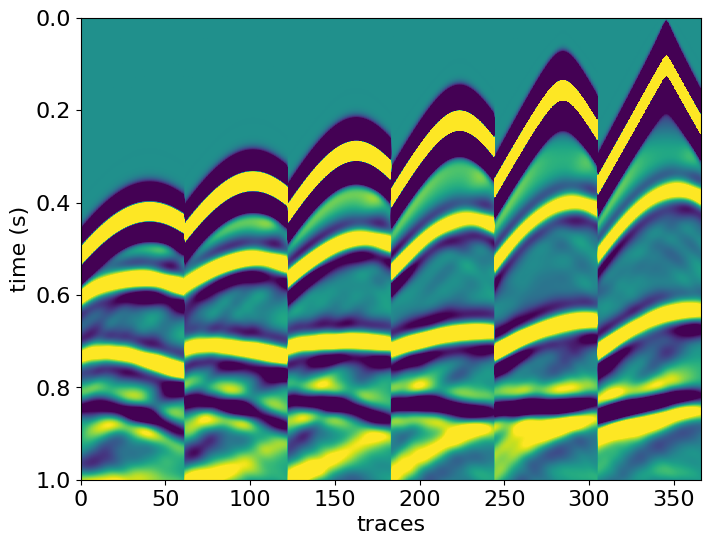

(554, 366)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


In [56]:
modeling_3D_swath(list_x,list_y)

In [40]:
num_swath = 9
L_rec = 600 # Length line of receivers
L_sx = 500 # Length line of sources
x0_x = list_x[num_swath-1] # Initial position in X
x0_y = list_y[num_swath-1] # Initial position in Y

In [20]:
L_rec = 1000 # Length line of receivers
L_sx = 800 # Length line of sources
x0_x = 0 # Initial position in X
x0_y = 0 # Initial position in Y

In [49]:
num_sources = 25

sx_line = np.linspace(x0_y+10,L_sx+x0_y-10,num=num_sources)

num_receivers = 61

rec_line = np.linspace(x0_x,L_rec+x0_x,num=num_receivers)

print(x0_x,x0_y)

print(np.diff(rec_line), len(rec_line))  

print(np.diff(sx_line), len(sx_line))  

400 0
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10.] 61
[20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20.] 25


In [50]:
num_rec_lines = 6

num_sx_lines = 3

rec_lines = np.linspace(x0_y,L_sx+x0_y,num=num_rec_lines)

sx_lines = np.linspace(x0_x+200,x0_x+400,num=num_sx_lines)

print(np.diff(rec_lines), len(rec_lines))  
print(np.diff(sx_lines), len(sx_lines)) 

[100. 100. 100. 100. 100.] 6
[100. 100.] 3


(6, 61)
[[ 400.  410.  420.  430.  440.  450.  460.  470.  480.  490.  500.  510.
   520.  530.  540.  550.  560.  570.  580.  590.  600.  610.  620.  630.
   640.  650.  660.  670.  680.  690.  700.  710.  720.  730.  740.  750.
   760.  770.  780.  790.  800.  810.  820.  830.  840.  850.  860.  870.
   880.  890.  900.  910.  920.  930.  940.  950.  960.  970.  980.  990.
  1000.]
 [ 400.  410.  420.  430.  440.  450.  460.  470.  480.  490.  500.  510.
   520.  530.  540.  550.  560.  570.  580.  590.  600.  610.  620.  630.
   640.  650.  660.  670.  680.  690.  700.  710.  720.  730.  740.  750.
   760.  770.  780.  790.  800.  810.  820.  830.  840.  850.  860.  870.
   880.  890.  900.  910.  920.  930.  940.  950.  960.  970.  980.  990.
  1000.]
 [ 400.  410.  420.  430.  440.  450.  460.  470.  480.  490.  500.  510.
   520.  530.  540.  550.  560.  570.  580.  590.  600.  610.  620.  630.
   640.  650.  660.  670.  680.  690.  700.  710.  720.  730.  740.  750.
   760.  770

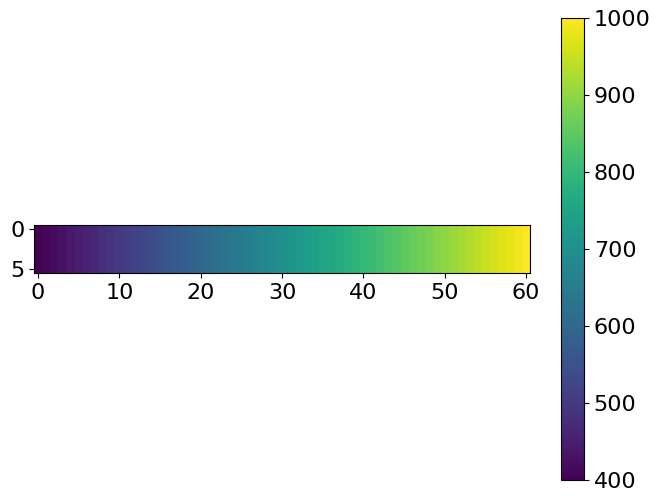

In [51]:
matriz_rec = np.zeros((num_rec_lines,len(rec_line)))

     
for i in range(num_rec_lines):
    for j in range(len(rec_line)):
        matriz_rec[i,j] = rec_line[j]
        
print(matriz_rec.shape)
print(matriz_rec)
plt.imshow(matriz_rec)
plt.colorbar()

(25, 3)
[[490. 490. 490.]
 [470. 470. 470.]
 [450. 450. 450.]
 [430. 430. 430.]
 [410. 410. 410.]
 [390. 390. 390.]
 [370. 370. 370.]
 [350. 350. 350.]
 [330. 330. 330.]
 [310. 310. 310.]
 [290. 290. 290.]
 [270. 270. 270.]
 [250. 250. 250.]
 [230. 230. 230.]
 [210. 210. 210.]
 [190. 190. 190.]
 [170. 170. 170.]
 [150. 150. 150.]
 [130. 130. 130.]
 [110. 110. 110.]
 [ 90.  90.  90.]
 [ 70.  70.  70.]
 [ 50.  50.  50.]
 [ 30.  30.  30.]
 [ 10.  10.  10.]]


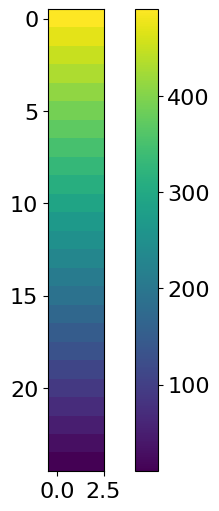

In [52]:
matriz_sx = np.zeros((len(sx_line),num_sx_lines))
print(matriz_sx.shape)

for i in range(len(sx_line)):  
    for j in range(num_sx_lines):
        matriz_sx[len(sx_line)-i-1,j] = sx_line[i]
        

print(matriz_sx)
plt.imshow(matriz_sx)
plt.colorbar()

Text(0, 0.5, 'Distance Y (m)')

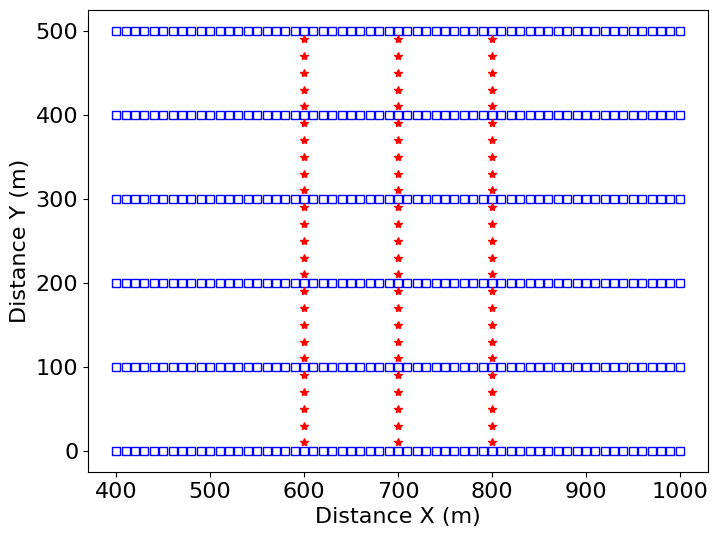

In [53]:
plt.figure()
for i in range(num_rec_lines):
    for j in range(len(rec_line)):
        plt.plot(rec_line[j],rec_lines[i],'bs',mfc='none')
        
for i in range(num_sx_lines):
    for j in range(len(sx_line)):
        plt.plot(sx_lines[i],sx_line[j],'r*')
        
plt.xlabel('Distance X (m)')
plt.ylabel('Distance Y (m)')

Text(0, 0.5, 'Distance Y (m)')

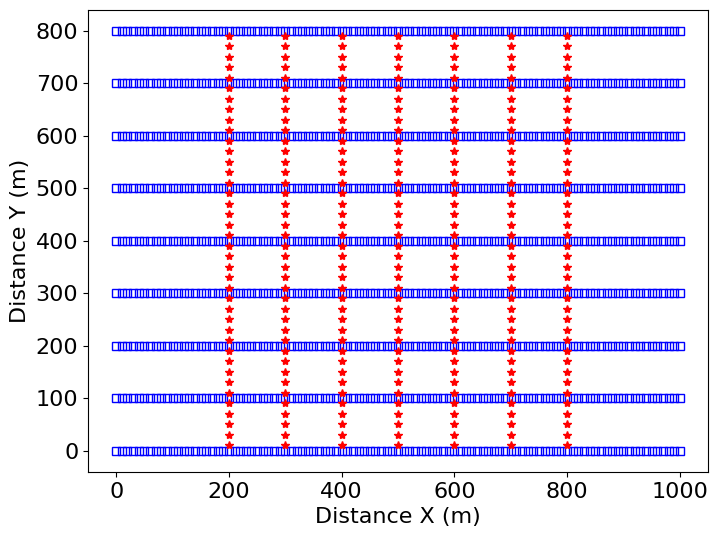

In [38]:
plt.figure()
for i in range(num_rec_lines):
    for j in range(len(rec_line)):
        plt.plot(rec_line[j],rec_lines[i],'bs',mfc='none')
        
for i in range(num_sx_lines):
    for j in range(len(sx_line)):
        plt.plot(sx_lines[i],sx_line[j],'r*')
        
plt.xlabel('Distance X (m)')
plt.ylabel('Distance Y (m)')

In [449]:
i=24
j=2

inicial = rec_lines[0]
final = rec_lines[-1]
print(inicial,final)

line_rec_x = matriz_rec[0,:]
line_rec_y = np.linspace(inicial,final,len(matriz_rec[:,0])) 


print(line_rec_x,len(line_rec_x))
print(line_rec_y,len(line_rec_y))

sx_x = 200+(j*int(np.diff(sx_lines)[0]))
sx_y = sx_line[i]
print(sx_x,sx_y)

0.0 500.0
[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360. 370. 380. 390. 400. 410.
 420. 430. 440. 450. 460. 470. 480. 490. 500. 510. 520. 530. 540. 550.
 560. 570. 580. 590. 600.] 61
[  0. 100. 200. 300. 400. 500.] 6
400 490.0


In [407]:
t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

#Source

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)
src.coordinates.data[0, 0] = sx_x
src.coordinates.data[0, 1] = sx_y
src.coordinates.data[0, -1] = 20.  # Depth is 20m

#Receiver
num_receivers = len(line_rec_x)
num_lines = len(line_rec_y)

rec = Receiver(name='rec', grid=model.grid, npoint=num_receivers*num_lines, time_range=time_range)
for i in range(num_lines):
    rec.coordinates.data[i*num_receivers:(i+1)*num_receivers, 0] = line_rec_x  
    rec.coordinates.data[i*num_receivers:(i+1)*num_receivers, 1] = line_rec_y[i]   
    print(line_rec_y[i])
rec.coordinates.data[:, -1] = 20. # Depth is 20m


100.0
200.0
300.0
400.0
500.0
600.0


In [408]:
dt

1.811

In [409]:
# Define the wavefield with the size of the model
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=4)
u

u(t, x, y, z)

In [410]:
u.data.shape

(3, 161, 161, 161)

In [411]:
u.shape == u.data.shape

True

In [412]:
isinstance(u.data, np.ndarray)

True

In [413]:
u.dx2.evaluate

-2.5*u(t, x, y, z)/h_x**2 - 0.0833333333*u(t, x - 2*h_x, y, z)/h_x**2 + 1.33333333*u(t, x - h_x, y, z)/h_x**2 + 1.33333333*u(t, x + h_x, y, z)/h_x**2 - 0.0833333333*u(t, x + 2*h_x, y, z)/h_x**2

In [414]:
# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde

damp(x, y, z)*Derivative(u(t, x, y, z), t) - Derivative(u(t, x, y, z), (x, 2)) - Derivative(u(t, x, y, z), (y, 2)) - Derivative(u(t, x, y, z), (z, 2)) + Derivative(u(t, x, y, z), (t, 2))/vp(x, y, z)**2

In [415]:
u.forward

u(t + dt, x, y, z)

In [416]:
u.forward.dx

Derivative(u(t + dt, x, y, z), x)

In [417]:
stencil = Eq(u.forward, solve(pde, u.forward))
stencil

Eq(u(t + dt, x, y, z), (-(-2.0*u(t, x, y, z)/dt**2 + u(t - dt, x, y, z)/dt**2)/vp(x, y, z)**2 + Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2)) + damp(x, y, z)*u(t, x, y, z)/dt)/(damp(x, y, z)/dt + 1/(dt**2*vp(x, y, z)**2)))

In [418]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

In [419]:
op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

In [420]:
op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` ran in 4.06 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=4.030695999999998, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0006700000000000071, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.02607999999999995, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [421]:
print(rec.data.shape) # 10,10,10 posición (4,10)

(554, 366)


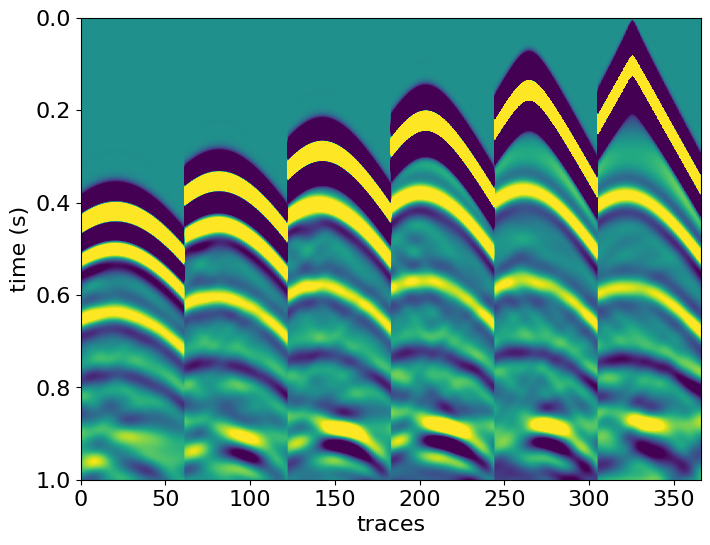

In [422]:
plt.imshow(rec.data, cmap='viridis', aspect='auto', extent=(0,rec.data.shape[1],1,0), vmax=0.01, vmin=-0.01)
plt.xlabel('traces')
plt.ylabel('time (s)')
plt.show()

In [423]:
survey = []
ffid = 1


for j in range(num_sx_lines):
    for i in range(num_sources):
        print('FFID: ',ffid)
        inicial = rec_lines[0]
        final = rec_lines[-1]
        
        line_rec_x = matriz_rec[0,:]
        line_rec_y = np.linspace(inicial,final,len(matriz_rec[:,0])) 


        print(len(line_rec_x),len(line_rec_y))

        sx_x = 200+(j*int(np.diff(sx_lines)[0]))
        sx_y = sx_line[i]
        print(sx_x,sx_y)
        
        t0 = 0.  # Simulation starts a t=0
        tn = 1000.  # Simulation last 1 second (1000 ms)
        dt = model.critical_dt  # Time step from model grid spacing

        time_range = TimeAxis(start=t0, stop=tn, step=dt)

        #Source

        f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
        src = RickerSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)
        src.coordinates.data[0, 0] = sx_x
        src.coordinates.data[0, 1] = sx_y
        src.coordinates.data[0, -1] = 20.  # Depth is 20m
#swath 6 - 500m en Y
        #Receiver
        num_receivers = len(line_rec_x)
        num_lines = len(line_rec_y)

        rec = Receiver(name='rec', grid=model.grid, npoint=num_receivers*num_lines, time_range=time_range)

        for k in range(num_lines):
            rec.coordinates.data[k*num_receivers:(k+1)*num_receivers, 0] = line_rec_x  
            rec.coordinates.data[k*num_receivers:(k+1)*num_receivers, 1] = line_rec_y[k]   

        rec.coordinates.data[:, -1] = 20. # Depth is 20m

        # Define the wavefield with the size of the model
        u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=4)

        # We can now write the PDE
        pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

        stencil = Eq(u.forward, solve(pde, u.forward))

        # Finally we define the source injection and receiver read function to generate the corresponding code
        src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

        # Create interpolation expression for receivers
        rec_term = rec.interpolate(expr=u.forward)

        op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

        op(time=time_range.num-1, dt=model.critical_dt)

        survey.append(rec.data)

        ffid +=1
print(len(survey))

FFID:  1
61 6
200 110.0


Operator `Kernel` ran in 4.27 s


FFID:  2
61 6
200 130.0


Operator `Kernel` ran in 3.83 s


FFID:  3
61 6
200 150.0


Operator `Kernel` ran in 3.89 s


FFID:  4
61 6
200 170.0


Operator `Kernel` ran in 3.85 s


FFID:  5
61 6
200 190.0


Operator `Kernel` ran in 3.83 s


FFID:  6
61 6
200 210.0


Operator `Kernel` ran in 3.92 s


FFID:  7
61 6
200 230.0


Operator `Kernel` ran in 3.84 s


FFID:  8
61 6
200 250.0


Operator `Kernel` ran in 3.93 s


FFID:  9
61 6
200 270.0


Operator `Kernel` ran in 3.91 s


FFID:  10
61 6
200 290.0


Operator `Kernel` ran in 3.82 s


FFID:  11
61 6
200 310.0


Operator `Kernel` ran in 3.82 s


FFID:  12
61 6
200 330.0


Operator `Kernel` ran in 3.89 s


FFID:  13
61 6
200 350.0


Operator `Kernel` ran in 3.83 s


FFID:  14
61 6
200 370.0


Operator `Kernel` ran in 3.85 s


FFID:  15
61 6
200 390.0


Operator `Kernel` ran in 3.83 s


FFID:  16
61 6
200 410.0


Operator `Kernel` ran in 3.82 s


FFID:  17
61 6
200 430.0


Operator `Kernel` ran in 3.84 s


FFID:  18
61 6
200 450.0


Operator `Kernel` ran in 3.85 s


FFID:  19
61 6
200 470.0


Operator `Kernel` ran in 3.78 s


FFID:  20
61 6
200 490.0


Operator `Kernel` ran in 3.79 s


FFID:  21
61 6
200 510.0


Operator `Kernel` ran in 3.80 s


FFID:  22
61 6
200 530.0


Operator `Kernel` ran in 3.78 s


FFID:  23
61 6
200 550.0


Operator `Kernel` ran in 3.82 s


FFID:  24
61 6
200 570.0


Operator `Kernel` ran in 3.80 s


FFID:  25
61 6
200 590.0


Operator `Kernel` ran in 3.79 s


FFID:  26
61 6
300 110.0


Operator `Kernel` ran in 3.80 s


FFID:  27
61 6
300 130.0


Operator `Kernel` ran in 3.81 s


FFID:  28
61 6
300 150.0


Operator `Kernel` ran in 3.79 s


FFID:  29
61 6
300 170.0


Operator `Kernel` ran in 3.80 s


FFID:  30
61 6
300 190.0


Operator `Kernel` ran in 3.77 s


FFID:  31
61 6
300 210.0


Operator `Kernel` ran in 3.80 s


FFID:  32
61 6
300 230.0


Operator `Kernel` ran in 3.80 s


FFID:  33
61 6
300 250.0


Operator `Kernel` ran in 3.82 s


FFID:  34
61 6
300 270.0


Operator `Kernel` ran in 3.79 s


FFID:  35
61 6
300 290.0


Operator `Kernel` ran in 3.78 s


FFID:  36
61 6
300 310.0


Operator `Kernel` ran in 3.83 s


FFID:  37
61 6
300 330.0


Operator `Kernel` ran in 3.81 s


FFID:  38
61 6
300 350.0


Operator `Kernel` ran in 3.82 s


FFID:  39
61 6
300 370.0


Operator `Kernel` ran in 3.84 s


FFID:  40
61 6
300 390.0


Operator `Kernel` ran in 3.82 s


FFID:  41
61 6
300 410.0


Operator `Kernel` ran in 3.81 s


FFID:  42
61 6
300 430.0


Operator `Kernel` ran in 3.87 s


FFID:  43
61 6
300 450.0


Operator `Kernel` ran in 3.79 s


FFID:  44
61 6
300 470.0


Operator `Kernel` ran in 3.79 s


FFID:  45
61 6
300 490.0


Operator `Kernel` ran in 3.85 s


FFID:  46
61 6
300 510.0


Operator `Kernel` ran in 3.82 s


FFID:  47
61 6
300 530.0


Operator `Kernel` ran in 3.83 s


FFID:  48
61 6
300 550.0


Operator `Kernel` ran in 3.81 s


FFID:  49
61 6
300 570.0


Operator `Kernel` ran in 3.82 s


FFID:  50
61 6
300 590.0


Operator `Kernel` ran in 3.85 s


FFID:  51
61 6
400 110.0


Operator `Kernel` ran in 3.82 s


FFID:  52
61 6
400 130.0


Operator `Kernel` ran in 3.85 s


FFID:  53
61 6
400 150.0


Operator `Kernel` ran in 3.83 s


FFID:  54
61 6
400 170.0


Operator `Kernel` ran in 3.81 s


FFID:  55
61 6
400 190.0


Operator `Kernel` ran in 3.82 s


FFID:  56
61 6
400 210.0


Operator `Kernel` ran in 3.83 s


FFID:  57
61 6
400 230.0


Operator `Kernel` ran in 3.83 s


FFID:  58
61 6
400 250.0


Operator `Kernel` ran in 3.80 s


FFID:  59
61 6
400 270.0


Operator `Kernel` ran in 3.82 s


FFID:  60
61 6
400 290.0


Operator `Kernel` ran in 3.81 s


FFID:  61
61 6
400 310.0


Operator `Kernel` ran in 3.82 s


FFID:  62
61 6
400 330.0


Operator `Kernel` ran in 3.83 s


FFID:  63
61 6
400 350.0


Operator `Kernel` ran in 3.85 s


FFID:  64
61 6
400 370.0


Operator `Kernel` ran in 3.82 s


FFID:  65
61 6
400 390.0


Operator `Kernel` ran in 3.82 s


FFID:  66
61 6
400 410.0


Operator `Kernel` ran in 3.84 s


FFID:  67
61 6
400 430.0


Operator `Kernel` ran in 3.80 s


FFID:  68
61 6
400 450.0


Operator `Kernel` ran in 3.84 s


FFID:  69
61 6
400 470.0


Operator `Kernel` ran in 3.82 s


FFID:  70
61 6
400 490.0


Operator `Kernel` ran in 3.81 s


FFID:  71
61 6
400 510.0


Operator `Kernel` ran in 3.82 s


FFID:  72
61 6
400 530.0


Operator `Kernel` ran in 3.83 s


FFID:  73
61 6
400 550.0


Operator `Kernel` ran in 3.82 s


FFID:  74
61 6
400 570.0


Operator `Kernel` ran in 3.81 s


FFID:  75
61 6
400 590.0


Operator `Kernel` ran in 3.80 s


75


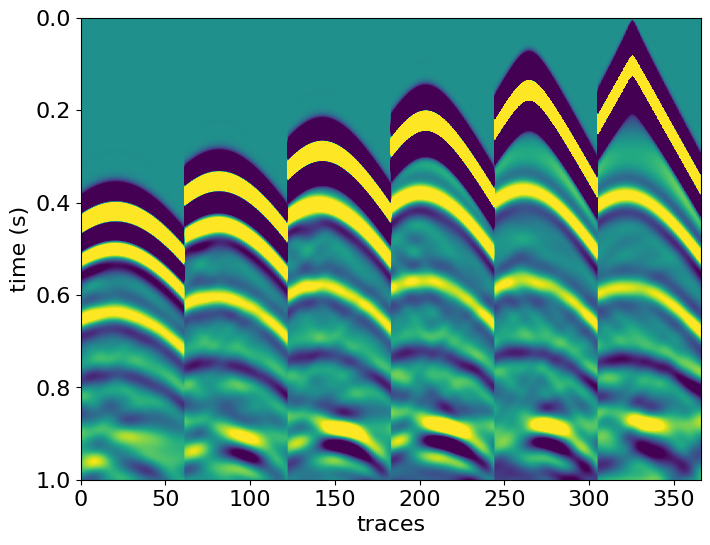

In [424]:
plt.imshow(survey[74], cmap='viridis', aspect='auto', extent=(0,rec.data.shape[1],1,0), vmax=0.01, vmin=-0.01)
plt.xlabel('traces')
plt.ylabel('time (s)')
plt.show()

In [425]:
survey[74].shape

(554, 366)

In [467]:
num_swath = 1
for i in range(len(survey)): 
    np.savetxt('data/datatxt2/swath_'+str(num_swath)+'/file_'+str(i+1)+'.txt',survey[i].T.ravel())
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


In [ ]:
#swath 6 - 200m en Y y 200 en X